# Fire Spread Modelling

## Connect to Drive

In [ ]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive

drive.mount(ROOT)  

Mounted at /content/drive


In [ ]:
import os
rootPath = "/content/drive/My Drive/California FireTrends (2012-2020)"
os.chdir(rootPath)

## Import Libraries

In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [ ]:
import pandas as pd
import time
from datetime import datetime, date, time, timedelta
import io
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os 
import sklearn
from sklearn.metrics import mean_squared_error
from math import sqrt
#from heatmap import *
import geopandas as gpd
from shapely.geometry import Point
import folium
import rtree

In [ ]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext): 
              file_list.append(os.path.join(path, names))
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath + "/"

## Compile all datasets

In [ ]:
magnitude_df = pd.read_csv('MultiSpread/daily_magnitude_2012_2020.csv')
gridmet_2012_2020 = pd.read_csv('Variables/Final_Variables/gridmet_2012_2020.csv')
daymet_2012_2019 = pd.read_csv('Variables/Final_Variables/daymet_2012_2019.csv')
merged_RAWS_2012_2020 = pd.read_csv('Variables/Final_Variables/RAWS_2012_2020.csv')
Interpolated_CA = gpd.read_file('Products/ALL_2012_2020/ALL_2012_2020.geojson')

In [ ]:
Interpolated_CA = Interpolated_CA[['JulianDay', 'YRJD', 'Fire', 'Year', 'Month', 'Day', 'Date', 'Area (acres)', 'Area (ha)', 'geometry']]

In [ ]:
Interpolated_CA = Interpolated_CA[['Fire', 'Date', 'geometry']]

In [ ]:
import pandas as pd
from functools import reduce

df_list = [Interpolated_CA, gridmet_2012_2020, magnitude_df]
full_dataset_2020_2012 = reduce(lambda  left,right: pd.merge(left,right,on=['Fire', 'Date'],how='left'), df_list)

In [ ]:
full_dataset_2020_2012 = gpd.GeoDataFrame(full_dataset_2020_2012, geometry = 'geometry')

In [ ]:
full_dataset_2020_2012['FireID'].nunique()

500

In [ ]:
full_dataset_2020_2012

In [ ]:
df_list = [Interpolated_CA, merged_RAWS_2012_2020, magnitude_df]
raws_dataset_2020_2012 = reduce(lambda  left,right: pd.merge(left,right,on=['Fire', 'Date'],
                                            how='left'), df_list)
raws_dataset_2020_2012 = gpd.GeoDataFrame(raws_dataset_2020_2012, geometry = 'geometry')

In [ ]:
merged_RAWS_2012_2020['FireID'].nunique()

151

## Spatial Join perimeters and ecoregions

In [ ]:
from pathlib import Path
import pandas
import geopandas

In [ ]:
eco13 = gpd.read_file('Data/ca_eco_l3/ca_eco_l3.shp')
eco13 = eco13.reset_index()
eco13 = eco13.rename(columns={'index': 'ecoID'})

In [ ]:
eco13 = eco13.to_crs(Interpolated_CA.crs)
fire_info_df = gpd.overlay(Interpolated_CA, eco13, how="intersection")

In [ ]:
fire_info_df = fire_info_df.rename(columns={
                      'NA_L3NAME': 'EcoRegion', 
                      'EcoID' : 'ecoID'
                    })

In [ ]:
eco13 = eco13.to_crs(full_dataset_2020_2012.crs)
grid_per_info = gpd.sjoin(full_dataset_2020_2012, eco13, how="left", op='intersects')

In [ ]:
grid_per_info = grid_per_info.drop(columns=['Unnamed: 0', '.geo', 'index_right'])

In [ ]:
grid_per_info_df = pd.DataFrame(grid_per_info)

In [ ]:
grid_per_info_df.to_csv(f'Final_Compiled_CSV/gridmet_compiled_2012_2020.csv', index= False)

In [ ]:
eco13 = eco13.to_crs(raws_dataset_2020_2012.crs)
raws_per_info = gpd.sjoin(raws_dataset_2020_2012, eco13, how="left", op='intersects')

In [ ]:
raws_per_info_df = pd.DataFrame(raws_per_info)

In [ ]:
raws_per_info.to_csv(f'Final_Compiled_CSV/raws_compiled_2012_2020.csv', index= False)

## Read-In Data

In [ ]:
# Running for primary model i.e. GRIDMET 
df = pd.read_csv(f'Final_Compiled_CSV/gridmet_compiled_2012_2020.csv', index_col=None)

# [UNCOMMENT to run entire script for RAWS i.e. secondary model]
# df = pd.read_csv(f'Final_Compiled_CSV/raws_compiled_2012_2020.csv', index_col=None)

In [ ]:
df['Aspect'] = np.cos(df['Aspect'])

In [ ]:
len(df)

4721

In [ ]:
# Rename variables 
df = df.rename(columns={'bi': 'BurningIndex', 
                        'erc': 'ERC',
                        'eto': 'Ref_ET_G', 
                        'etr': 'Ref_ET_A', 
                        'fm100': 'DFM100hr', 
                        'fm1000':'DFM1000hr', 
                        'pr':'precip',
                        'rmax': 'RH_Max', 
                        'rmin': 'RH_Min', 
                        'sph': 'spec_hum', 
                        'srad': 'solar_rad', 
                        'th':  'Wind_Dir',
                        'tmmn': 'Temp_Min', 
                        'tmmx': 'Temp_Max', 
                        'vpd': 'VPD_Mean', 
                        'vs': 'Wind_Speed', 
                      'NA_L3NAME': 'EcoRegion',
                    'shortHeight': 'VegHeight_0.5m', 
                    'medShortHeight':'VegHeight_1m', 
                    'medHeight':'VegHeight_1m+',
                    'Air_Temp_Max' : f'*Max Temp (\xb0F)',
                    'Wind_Max_mph' : f'*Max Wind (mph)',
                    'Fuel_Temp_Avg' : f'*Avg Fuel Temp (\xb0F)'
                    })

## Define Variables

### Explanatory Variables

In [ ]:
##Note: comment out particular variables based on if you are running for gridmet or raws
## Double quotes should be left commented out due to variable redundancy, etc.

responsVar = ['Fire','JulianDay', 'Area (acre', 'Area (ha)', '(DIR_Weighted)', 'DIR_MaxDist', 'DIST_MEDSTD',
       'Magnitude (max)', 'Magnitude (median)', 'Magnitude (stdv)',
       'Magnitude (lowerQ)', 'Magnitude (upperQ)', 'Year', 'EcoRegion', 'ecoID', 'FireID']
      
topo_vars=  ['Aspect', 
             'Valley', 
             'LowerSlope', 
             'MidSlope', 
             'UpperSlope', 'Ridge',
             'DEM',
             'Slope', 
             'TOPO_DIV']
 
fuel_vars = ['EVI',
             'NDMI', 
             'NDMIDelta', 
             'NDVI', 
             'Annual_NDMI',
             'DFM1000hr',  
             'DFM100hr',  
             'Ref_ET_G',
             'Ref_ET_A',

## RAWS Variables 
            #  'Fuel_Temp_Avg',
            #  'Fuel_Moist_Per'
            #  '*Avg Fuel Temp (\xb0F)',
            #  'Fuel_Moist_Per'
             ]

fuel_amount= ['Annual_EVI', 
              'Annual_NDVI', 
              'CBD']
 
fuel_type = [
             'Barren', 
             'Conifer', 
             'Grassland', 
             'Hardwood', 
             'Riparian', 'Shrubland', 
             'Sparsely Vegetated'
             ]
 
FBFM_vars = ['FBFM10', 'FBFM11', 'FBFM12', 'FBFM2', 'FBFM3', 'FBFM4', 'FBFM5',
       'FBFM6', 'FBFM7', 'FBFM8', 'FBFM9','FBFM1']
       
fuelHeight_vars = ['TreeHeight_5m', 'TreeHeight_10m', 'TreeHeight_25m',
       'TreeHeight_50m', 'TreeHeight_50m+',  'VegHeight_0.5m', 
        'VegHeight_1m', 'VegHeight_1m+']
       
fireweather_vars = [
## GRIDMET Variables 
       'BurningIndex', 
       'ERC', 
       'Temp_Max', 
      #  'RH_Max', 
       'VPD_Mean', 
       'Temp_Min',  
       'RH_Min',
       'precip',
       'solar_rad',
       'Wind_Speed', 
       'FFWI',
         
# # RAWS Variables 
#          '*Max Wind (mph)', '*Max Temp (\xb0F)', 
#         #  'Total_Solar_Rad', 
#         #  'Wind_Avg_mph','Wind_Max_Avg',
#         #  'Wind_Max_mph', 
#         #  'Air_Temp_Max', 
#         #  'Air_Temp_Avg',
#           'Rel_Hum_Per',
#         #   'Dew_Point_Deg','Wet_Bulb',
#            'VPD'
           ]   
        
human_vars = ['travelCost']
 
indVar= topo_vars + fuel_vars + fuel_type + FBFM_vars + \
        fuelHeight_vars + fireweather_vars + human_vars + fuel_amount

In [ ]:
len(topo_vars), len(fuel_vars), len(fuel_type), len(fuel_amount), len(FBFM_vars), len(fuelHeight_vars), len(fireweather_vars) 

(9, 9, 7, 3, 12, 8, 10)

### Response Variables

In [ ]:
# 'DIR_WA', 'DIR_MaxDist', 'DIST_MEDSTD', 'Magnitude (max)','Magnitude (stdv)','Magnitude (lowerQ)', 
responsVar = ['Area (ha)', 'Magnitude (median)', 'Magnitude (max)', 'Magnitude (upperQ)', 'Fire', 'FireID', 'Year', 'EcoRegion', 'ecoID']

### Delete Variables

## Clean-up Data

In [ ]:
# clean out duplicates, na, areas = 0, nonsensical NDVI values 
spreadFile = df.drop_duplicates()
spreadFile = spreadFile.dropna()
spreadFile = spreadFile[spreadFile['Area (ha)'] != 0]
spreadFile = spreadFile[spreadFile['Annual_NDVI'] > -1]

In [ ]:
# create response and ind var DF
responsDF = spreadFile[responsVar]
indDF = spreadFile[indVar]

responsDF = responsDF.rename(columns={"Area (ha)": "Area", 'Magnitude (upperQ)': "upperQMag", 
                                      'Magnitude (median)' : 'medMag', 'Magnitude (max)' : 'maxMag'})

In [ ]:
# how many fires? 
print("Total Fires:", spreadFile.groupby(['Fire', 'Year']).ngroups)
print("Total Fires:", spreadFile['FireID'].nunique())
# how many total days? 
print("Total Days:", len(spreadFile))

In [ ]:
spreadFile.loc[spreadFile.ecoID == 5, 'EcoRegion'] = "Northern Coastal Sage"
spreadFile.loc[spreadFile.ecoID == 11, 'EcoRegion'] = "Southern Coastal Sage"
spreadFile.loc[spreadFile.ecoID == 8, 'EcoRegion'] = "Southern/Baja"
spreadFile.loc[spreadFile.ecoID == 2, 'EcoRegion'] = "Southern/Baja"
spreadFile.loc[spreadFile.ecoID == 2, 'ecoID'] = 8
spreadFile.loc[spreadFile.ecoID == 1, 'EcoRegion'] = "Northern Coastal Sage"
spreadFile.loc[spreadFile.ecoID == 1, 'ecoID'] = 5
spreadFile.loc[spreadFile.ecoID == 0, 'EcoRegion'] = "Klamath Mountains"
spreadFile.loc[spreadFile.ecoID == 0, 'ecoID'] = 7
spreadFile.loc[spreadFile.ecoID == 12, 'EcoRegion'] = "Cascades"
spreadFile.loc[spreadFile.ecoID == 12, 'ecoID'] = 3
spreadFile.loc[spreadFile.ecoID == 6, 'EcoRegion'] = "Northern Coastal Sage"
spreadFile.loc[spreadFile.ecoID == 6, 'ecoID'] = 5
spreadFile.loc[spreadFile.ecoID == 9, 'EcoRegion'] = "Klamath Mountains"
spreadFile.loc[spreadFile.ecoID == 9, 'ecoID'] = 7
spreadFile.loc[spreadFile.ecoID == 10, 'EcoRegion'] = "Southern Coastal Sage"
spreadFile.loc[spreadFile.ecoID == 10, 'ecoID'] = 11

In [ ]:

spreadFile.groupby(['EcoRegion', 'ecoID'])['JulianDay'].count().reset_index()

,EcoRegion,ecoID,JulianDay
0,Cascades,3.0,164
1,Klamath Mountains,7.0,1012
2,Northern Coastal Sage,5.0,466
3,Sierra Nevada,4.0,587
4,Southern Coastal Sage,11.0,98
5,Southern/Baja,8.0,139


In [ ]:
ID_list = spreadFile['EcoRegion'].unique().tolist()
ID_list

['Sierra Nevada',
 'Northern Coastal Sage',
 'Klamath Mountains',
 'Cascades',
 'Southern Coastal Sage',
 'Southern/Baja']

## Correlation

### Independent vs Dependent

In [ ]:
# make data ready for facet type plots 
ALL_data = spreadFile.copy()
ALL_data['EcoRegion'] = 'ALL'
ALL_data['ecoID'] = 0
frames = [ALL_data, spreadFile]
facet_data = pd.concat(frames, keys=spreadFile.columns.tolist())

In [ ]:
import scipy.stats  as stats
figOutPath = 'Figures'
p_val = []
r_val = [] 
vv = [] 
respVr = []
ecoR = [] 

ecoList = facet_data['EcoRegion'].unique().tolist()

facet_data['log(Area)'] = np.log10(facet_data['Area (ha)'])
respVars = ['Magnitude (upperQ)' , 'log(Area)']

for eco in ecoList: 
  eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
  for resp in respVars: 
      for var in indVar :
          r = stats.pearsonr(eco_df[var], eco_df[resp])
          r_val.append(round(r[0], 2))
          p_val.append(round(r[1], 10))
          ecoR.append(eco)
          vv.append(var)
          respVr.append(resp)
    
corrInfo = pd.DataFrame({'Explanatory Variables':vv,  
                         'r_score':r_val, 'p Value': p_val, 
                         'Response Variables': respVr,
                         'EcoRegion': ecoR})
corrInfo = corrInfo.reindex(corrInfo.r_score.abs().sort_values(ascending=False).index)
# corrInfo.to_csv(os.path.join(figOutPath, 'Corr_CSV', 'ALL' + "_corr.csv"))

An input array is constant; the correlation coefficent is not defined.


In [ ]:
VarType_Dic = {'Topography': topo_vars, \
               'Fuel': fuel_vars + fuel_type + fuel_amount + \
               fuelHeight_vars + FBFM_vars ,\
               'Weather': fireweather_vars, \
               'Human': human_vars}

d = {k: oldk for oldk, oldv in VarType_Dic.items() for k in oldv}

corrInfo["Type"] = corrInfo["Explanatory Variables"].map(d)

In [ ]:
corrInfo = df[df['EcoRegion'] == eco]
corrInfo = corrInfo.reindex(corrInfo.r_score.abs().sort_values(ascending=False).index)
corList = corrInfo['Explanatory Variables'].unique().tolist()[:15]
filt_DF = corrInfo[corrInfo['Explanatory Variables'].isin(corList)]
filt_DF = filt_DF.sort_values(by=['EcoRegion'])
filt_DF = filt_DF.sort_values(by=['Type', 'r_score'], ascending=False)

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)

def getTop10Corr(eco, df):
  corrInfo = df[df['EcoRegion'] == eco]
  corrInfo = corrInfo.reindex(corrInfo.r_score.abs().sort_values(ascending=False).index)
  corList = corrInfo['Explanatory Variables'].unique().tolist()[:10]
  filt_DF = corrInfo[corrInfo['Explanatory Variables'].isin(corList)]
  filt_DF = filt_DF.sort_values(by=['EcoRegion'])
  filt_DF = filt_DF.sort_values(by=['Type', 'r_score'], ascending=False)
  piv_corr = pd.pivot_table(filt_DF, values=['p Value','r_score'], index=['EcoRegion', 'Explanatory Variables', 'Type'],
                    columns=['Response Variables']).reset_index()
  piv_corr.columns = ['EcoRegion', 'Explanatory Variables', 'Type', 'Mag_p', 'Area_p', 'Mag_r', 'Area_r']



  figOutPath = 'Figures'
  sns.set(style="whitegrid", font_scale=1.3)

  lut = dict(zip(filt_DF['Type'].unique(), ['#0210d4', # Weather
                                            # '#e37d00', # Topo
                                            '#035e23',# Fuel
                                            '#035e23'# Fuel
                                            ])) 
  row_colors = filt_DF['Type'].map(lut)
  colors = ['#718096', '#CBD5E0']

  g = sns.catplot(x="r_score", y="Explanatory Variables", 
                    data = filt_DF, col="EcoRegion",  #col_wrap=3, 
                    hue = 'Response Variables', orient="h", kind="bar", 
                    palette= sns.set_palette(colors),legend=False, height=5.6,
                    hue_order=["Magnitude (upperQ)", "log(Area)"],
                    ) 
  g.set_titles(col_template = '{col_name}')

  for tick_label in g.axes.flat:
    for ylabel in tick_label.get_yticklabels():
      tick_text = ylabel.get_text()
      species_name = filt_DF.loc[filt_DF['Explanatory Variables'] == tick_text, 'Type'].tolist()
      ylabel.set_color(lut[species_name[0]])

  plt.tight_layout() # Full_FacetCorr.png; ALL.png
  eco = eco.replace('/', '')
  plt.savefig(os.path.join(figOutPath, 'Correlations', f"{eco}_ALL.png"), dpi = 400)

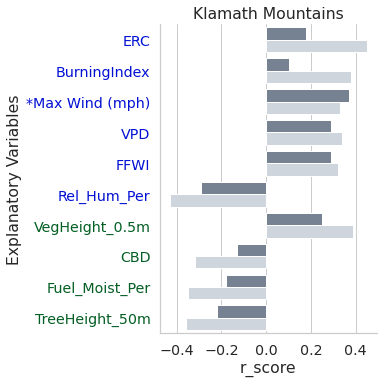

In [ ]:
getTop10Corr('Klamath Mountains', corrInfo)
getTop10Corr('Sierra Nevada', corrInfo)
getTop10Corr('Northern Coastal Sage', corrInfo)
getTop10Corr('Southern Coastal Sage', corrInfo)
getTop10Corr('Cascades', corrInfo)
getTop10Corr('Southern/Baja', corrInfo)

In [ ]:
piv_corr = pd.pivot_table(filt_DF, values=['p Value','r_score'], index=['EcoRegion', 'Explanatory Variables', 'Type'],
                    columns=['Response Variables']).reset_index()
piv_corr.columns = ['EcoRegion', 'Explanatory Variables', 'Type', 'Mag_p', 'Area_p', 'Mag_r', 'Area_r']
sample = piv_corr[piv_corr['EcoRegion']=='Sierra Nevada']
# sample.sort_values(by=['Area_r'], ascending=False)

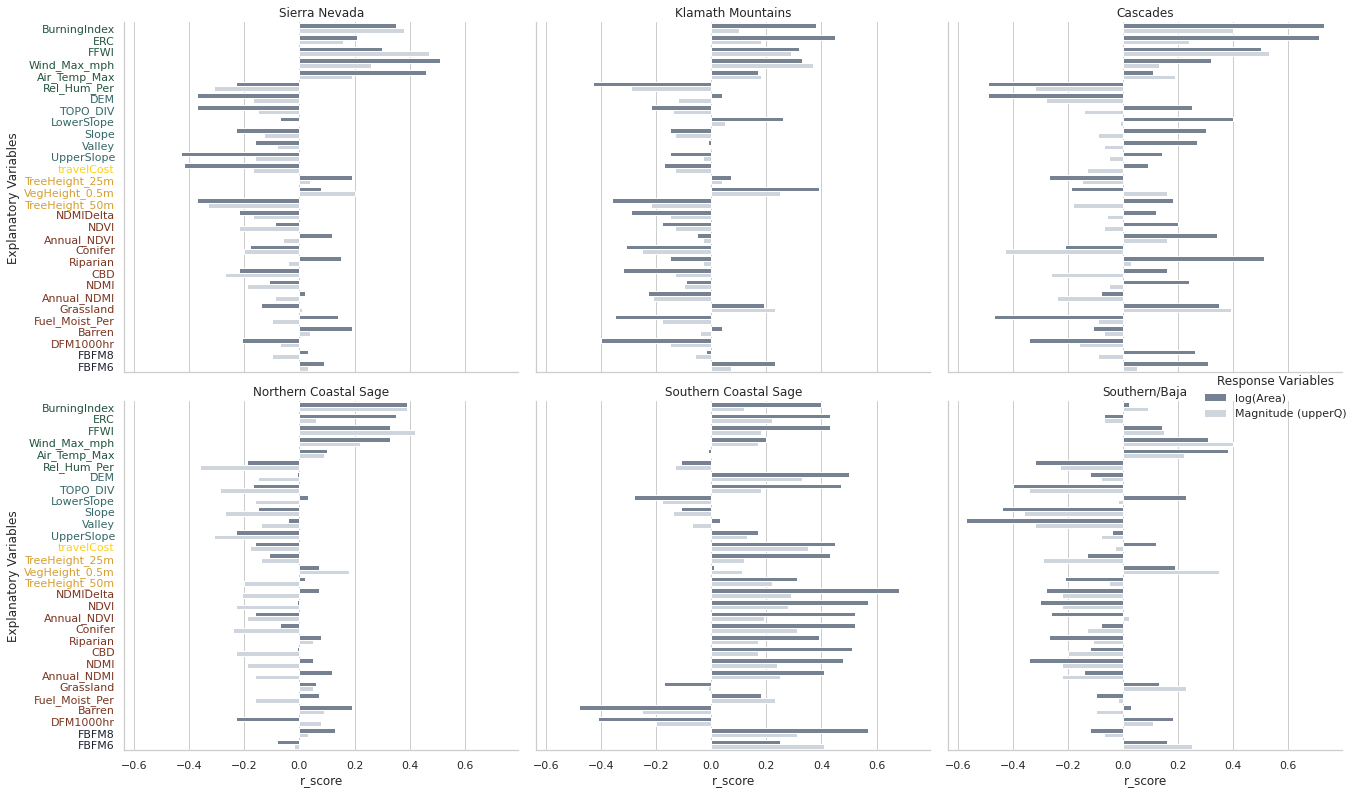

In [ ]:
figOutPath = 'Figures'
sns.set(style="whitegrid", font_scale=1)

lut = dict(zip(filt_DF['Type'].unique(), ['#22543D', # Fuel
                                          '#336666',
                                          '#ffd111',
                                          '#D69E2E', # Human
                                          '#7B341E', # Topo
                                          '#1A202C'])) # Weather
row_colors = filt_DF['Type'].map(lut)
colors = ['#718096', '#CBD5E0']

g = sns.catplot(x="r_score", y="Explanatory Variables", 
                  data = filt_DF, col="EcoRegion",  col_wrap=3, 
                  hue = 'Response Variables', orient="h", kind="bar", 
                  palette= sns.set_palette(colors),legend=True, height=5.6,
                  #hue_order=["Magnitude (upperQ)", "log(Area)"],
                  col_order=['Sierra Nevada', 'Klamath Mountains', 'Cascades',
                                   'Northern Coastal Sage', 'Southern Coastal Sage',
                                   'Southern/Baja']) 
g.set_titles(col_template = '{col_name}')

for tick_label in g.axes.flat:
  for ylabel in tick_label.get_yticklabels():
    tick_text = ylabel.get_text()
    species_name = filt_DF.loc[filt_DF['Explanatory Variables'] == tick_text, 'Type'].tolist()
    ylabel.set_color(lut[species_name[0]])

plt.tight_layout() # Full_FacetCorr.png; ALL.png
plt.savefig(os.path.join(figOutPath, 'Correlations', "ALL.png"), dpi = 150)

### Area vs Magnitude

In [ ]:
# Correlation between Response Variables: Area + Magnitude 
for eco in ecoList: 
  eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
  cor_df = eco_df[['Area (ha)', 'Magnitude (median)', 'Magnitude (upperQ)', 'EcoRegion']].reset_index()
  r = stats.pearsonr(cor_df['Area (ha)'], cor_df['Magnitude (median)'])
  print(eco, r)

ALL (0.37291782340663304, 3.2748187961352684e-82)
Sierra Nevada (0.5139737991957313, 6.882965511852183e-41)
Northern Coastal Sage (0.25543906438263114, 2.2394820467006168e-08)
Klamath Mountains (0.37601842806197283, 2.4483960268196395e-35)
Cascades (0.3483486963050319, 4.856034915890587e-06)
Southern Coastal Sage (0.3296312540374161, 0.0009181977406182663)
Southern/Baja (0.6552775837608439, 2.097093969545497e-18)


## Linear Relationships

In [ ]:
spreadFile['Area_log'] = np.log(spreadFile['Area (ha)'])
spreadFile['Mag_log'] = np.log(spreadFile['Magnitude (upperQ)'])
piv_sample = pd.melt(spreadFile, id_vars=['Area_log', 'EcoRegion'], value_vars=
                    topo_vars + fuel_vars + fuel_type + FBFM_vars + \
                    fuelHeight_vars + fireweather_vars + human_vars
        , var_name='Variables', value_name='Standardized Value')
piv_sample

,Area_log,EcoRegion,Variables,Standardized Value
0,4.677287,Sierra Nevada,Aspect,0.848984
1,7.878396,Sierra Nevada,Aspect,-0.932914
2,8.200648,Sierra Nevada,Aspect,-0.604244
3,7.530945,Sierra Nevada,Aspect,0.706776
4,7.244181,Sierra Nevada,Aspect,0.978340
...,...,...,...,...
140557,8.530102,Northern Coastal Sage,travelCost,1262.919799
140558,8.089602,Klamath Mountains,travelCost,955.340850
140559,8.089602,Northern Coastal Sage,travelCost,955.340850
140560,8.828044,Klamath Mountains,travelCost,1093.822837


In [ ]:
colors = ["blue", "orange", "grey", "sea green", "purple"]
sns.set(style="ticks")
sns.set(color_codes=True)
sns.set(font_scale=1.5)
pal = sns.xkcd_palette(colors)
p=sns.lmplot(x="Area_log", y="Standardized Value", hue = 'EcoRegion', col="Variables", data=piv_sample, sharex=False, sharey=False,
           col_wrap=5, ci=None, palette=pal, height=6, truncate = True) #line_kws={'color': 'red'}
p.set_titles(col_template = '{col_name}')
p.savefig(os.path.join(figOutPath, "linearplot.png"), dpi = 100)

Output hidden; open in https://colab.research.google.com to view.

## Spatial Modelling

In [ ]:
# plot pred vs actual 
def modelPlot(Y_Pred, Y_Test):
    output = pd.DataFrame()
    output['pred'] = Y_Pred
    output['actual'] = Y_Test
    sns.set(style="ticks")
    return sns.jointplot(output['pred'], output['actual'], kind="hex", color="#ffae19")

### Import Packages

In [ ]:
# import libraries
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.svm import SVR

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Model Selection

In [ ]:
columns = indDF.columns

sc = StandardScaler()

X = sc.fit_transform(indDF.values)
Y = np.log10(responsDF['Area'].values)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state=42)

gBoost = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50)

gBoost.fit(X_train,Y_train)
gBoost_predictions = gBoost.predict(X_test)
errors = np.square(abs((gBoost_predictions) - Y_test))
print("absolute error: ", np.exp(np.mean(errors)))
print("Test Score: " , gBoost.score(X_test,Y_test))

absolute error:  1.1649520130803743
Test Score:  0.722259150922991


In [ ]:
# Random Forest 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

regressor.fit(X_train,Y_train)
rf_predictions = regressor.predict(X_test)
errors = np.square(abs((rf_predictions) - Y_test))
print("absolute error: ", np.exp(np.mean(errors)))
print("Test Score: " , regressor.score(X_test,Y_test))

absolute error:  1.1224046089727813
Test Score:  0.829981538739043


In [ ]:
# pth = r'C:\\Users\\erica\\Desktop\\iPythonScript\\FireSpread\\'

# # Limit depth of tree to 3 levels
# rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
# rf_small.fit(X, Y)
# # Extract the small tree
# tree = rf_small.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree2.dot', feature_names = indDF.columns, rounded = True, precision = 1)
# # Use dot file to create a graph
# # P = pydotplus.graph_from_dot_file('tree.dot')
# # P

# # Write graph to a png file
# #P.write_png('tree.png')
# from subprocess import call
# #call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=200'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree2.png')

In [ ]:
# rf_small = RandomForestRegressor(n_estimators=100, max_depth = 5)
# rf_small.fit(X, Y)
# # Extract the small tree
# tree = rf_small.estimators_[30]


# dot_data = StringIO()
# export_graphviz(tree, out_file='socal.dot', 
#                 feature_names = columns,
#                 class_names = 'Area',
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)
# from subprocess import call
# call(['dot', '-Tpng', 'socal.dot', '-o', 'socal.png', '-Gdpi=200'], shell=True)

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'socal.png')

In [ ]:
# # Limit depth of tree to 3 levels
# rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
# rf_small.fit(X, Y)
# # Extract the small tree
# tree_small = rf_small.estimators_[5]
# # Save the tree as a png image
# export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# (graph, ) = pydot.graph_from_dot_file('small_tree.dot')
# graph.write_png('small_tree.png');

In [ ]:
#### SVM 
svr_regressor = SVR(kernel='rbf', gamma ='auto')
svr_regressor.fit(X_train,Y_train)
svr_predictions = svr_regressor.predict(X_test)
errors = np.square(abs((svr_predictions) - Y_test))
print("absolute error: ", np.exp(np.mean(errors)))
print("Test Score: ", svr_regressor.score(X_test,Y_test))

absolute error:  1.2487420960197473
Test Score:  0.6729345640561846


In [ ]:
CART_regressor=tree.DecisionTreeRegressor()
CART_regressor.fit(X_train, Y_train)
cart_predictions = CART_regressor.predict(X_test)
errors = np.square(abs((cart_predictions) - Y_test))
print("absolute error: " , np.mean(errors))
print("Test Score: ", CART_regressor.score(X_test,Y_test))

absolute error:  0.2638822150724449
Test Score:  0.6114701290793654


### K-Fold Validation

In [ ]:
from sklearn.model_selection import KFold
# k-fold cross validation 
RF_scores = []
SVM_scores = []
CART_scores = [] 
GBoost_scores = [] 
r2 = []
mse_score = [] 
method = []

## SVM 
svr_regressor = SVR(kernel='rbf', gamma='auto')
## RF 
RF_regressor = RandomForestRegressor(n_estimators = 100)
## CART 
CART_regressor = DecisionTreeRegressor()
## GBoost 
gBoost_regressor = GradientBoostingRegressor()

cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, Y_train, Y_test = X[train_index], X[test_index],Y[train_index], Y[test_index]
    RF_regressor.fit(X_train,Y_train)
    rf_predictions = regressor.predict(X_test)
    rf_errors = abs((rf_predictions) - Y_test)
    
    CART_regressor.fit(X_train,Y_train)
    cart_predictions = CART_regressor.predict(X_test)
    cart_errors = abs((cart_predictions) - Y_test)
    
    svr_regressor.fit(X_train,Y_train)
    svr_predictions = svr_regressor.predict(X_test)
    svr_errors = abs((svr_predictions) - Y_test)
    
    gBoost_regressor.fit(X_train,Y_train)
    gBoost_predictions = gBoost_regressor.predict(X_test)
    gBoosterrors = np.square(abs((gBoost_predictions) - Y_test))
    
    SVM_scores.append((svr_regressor.score(X_test, Y_test), np.mean(svr_errors)))
    r2.append(svr_regressor.score(X_test, Y_test))
    mse_score.append(np.mean(svr_errors))
    method.append("SVM")
    
    RF_scores.append((RF_regressor.score(X_test, Y_test), np.mean(rf_errors)))
    r2.append(RF_regressor.score(X_test, Y_test))
    mse_score.append(np.mean(rf_errors))
    method.append("RandomForest")
    
    CART_scores.append((CART_regressor.score(X_test, Y_test), np.mean(cart_errors)))
    r2.append(CART_regressor.score(X_test, Y_test))
    mse_score.append(np.mean(cart_errors))
    method.append("Cart")
    
    GBoost_scores.append((gBoost_regressor.score(X_test, Y_test), np.mean(gBoosterrors)))
    r2.append(gBoost_regressor.score(X_test, Y_test))
    mse_score.append(np.mean(gBoosterrors))
    method.append("GBoost")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


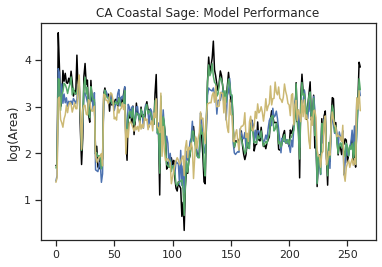

In [ ]:
sns.set(style ='ticks')
plt.plot(Y_test, 'black')
plt.plot(gBoost_predictions, 'b')
plt.plot(rf_predictions, 'g-')
plt.plot(svr_predictions, 'y')
plt.ylabel('log(Area)')
plt.title('CA Coastal Sage: Model Performance')
plt.savefig(os.path.join(figOutPath, ecoRegion + ".png"), dpi = 200)

In [ ]:
print("GBoost",np.mean([i[0] for i in GBoost_scores]), np.exp(np.mean([i[1] for i in GBoost_scores])))
print("RF", np.mean([i[0] for i in RF_scores]), np.exp(np.mean([i[1] for i in RF_scores])))
print("SVM", np.mean([i[0] for i in SVM_scores]), np.exp(np.mean([i[1] for i in SVM_scores])) )
print("CART",np.mean([i[0] for i in CART_scores]), np.exp(np.mean([i[1] for i in CART_scores])))

GBoost 0.7036761077190403 1.214804697498446
RF 0.6223835478562967 1.1513952975422383
SVM 0.33119670773886895 1.6596869729469457
CART 0.2630886912407546 1.7101790918243045


In [ ]:
model_performance = pd.DataFrame({'Method': method, 'R2_score': r2, 'MSE_score': mse_score})
#model_performance = pd.melt(model_performance, id_vars=['Method'], value_vars=['R2_score', 'MSE_score'])

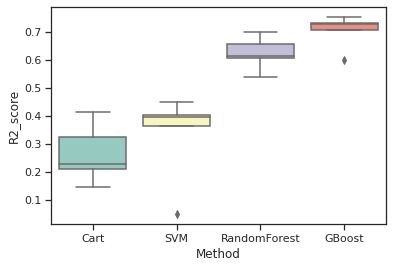

In [ ]:
sns.set(style='ticks')
ax = sns.boxplot(x="Method", y="R2_score",
                 data=model_performance, palette="Set3",
                order=["Cart", "SVM", 'RandomForest', 'GBoost'])

### Gradient Boosting

Response Variables: Magnitude, Area

EcoRegions: ['ALL',
 'Klamath Mountains',
 'Sierra Nevada',
 'Cascades',
 'California Coastal Sage, Chaparral, and Oak  Woodlands',
 'Southern and Baja California Pine-Oak Mountains']

In [ ]:
facet_data.groupby(['EcoRegion']).agg({'FireID': ['nunique', 'count'], 'Area (ha)': ['sum']}).reset_index()

EcoRegion  FireID           Area (ha)
                         nunique count           sum
0                    ALL     391  2466  3.684782e+06
1               Cascades      38   164  4.390111e+05
2      Klamath Mountains     111  1012  9.764389e+05
3  Northern Coastal Sage     135   466  1.330290e+06
4          Sierra Nevada      92   587  6.019330e+05
5  Southern Coastal Sage      42    98  1.382123e+05
6          Southern/Baja      36   139  1.988960e+05

In [ ]:
ecoList = facet_data['EcoRegion'].unique().tolist()
ecoList

['ALL',
 'Sierra Nevada',
 'Northern Coastal Sage',
 'Klamath Mountains',
 'Cascades',
 'Southern Coastal Sage',
 'Southern/Baja']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
respVars = ['Area (ha)', 'Magnitude (upperQ)']

ecoid = []
ecoName = []
resVar = []
RMSE = []
score = []

for res in respVars:
  for eco in ecoList: 
    eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
    eco_ID = eco_df['ecoID'].iloc[0]
    responsDF = eco_df[res]
    indDF = eco_df[indVar]
    print(res, eco)
    sc = StandardScaler()
    X = sc.fit_transform(indDF.values) #indDF.values 
    Y = np.log10(responsDF.values)
    #split 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)
    # call regressor
    gBoost = GradientBoostingRegressor(loss='ls' ,
                                       learning_rate=0.1, 
                                       n_estimators=1000
                                       )
    gBoost.fit(X_train,Y_train)
    gBoost_predictions = gBoost.predict(X_test)
    #errors = np.sqrt((np.square(abs((gBoost_predictions) - Y_test))))
    rmse = sqrt(mean_squared_error(Y_test, gBoost_predictions))
    
    # append results 
    ecoid.append(eco_ID)
    ecoName.append(eco)
    resVar.append(res)
    RMSE.append(rmse)
    score.append(abs(gBoost.score(X_test,Y_test)))

Area (ha) ALL
Area (ha) Sierra Nevada
Area (ha) Northern Coastal Sage
Area (ha) Klamath Mountains
Area (ha) Cascades
Area (ha) Southern Coastal Sage
Area (ha) Southern/Baja
Magnitude (upperQ) ALL
Magnitude (upperQ) Sierra Nevada
Magnitude (upperQ) Northern Coastal Sage
Magnitude (upperQ) Klamath Mountains
Magnitude (upperQ) Cascades
Magnitude (upperQ) Southern Coastal Sage
Magnitude (upperQ) Southern/Baja


In [ ]:
model_output = pd.DataFrame({'EcoRegion':ecoName,  
                             'EcoID': ecoid,
                             'Response Variables': resVar,
                             'Score': score,
                             'RMSE': RMSE})

In [ ]:
#[RAWS MODEL]
model_output
piv_output = pd.pivot_table(model_output, values=['Score', 'RMSE'], index=['EcoRegion', 'EcoID'],
                    columns=['Response Variables']).reset_index()
piv_output = piv_output.set_index('EcoRegion')
piv_output = piv_output.reindex(['Klamath Mountains', 'Sierra Nevada', 'Northern Coastal Sage', 'Southern Coastal Sage', #'California Coastal Sage, Chaparral, and Oak Woodlands',
                    'Cascades','Southern/Baja', 'ALL'])

piv_output.round(2)

EcoID      RMSE  ...     Score                   
Response Variables          Area (ha)  ... Area (ha) Magnitude (upperQ)
EcoRegion                              ...                             
Klamath Mountains       7.0      0.31  ...      0.81               0.60
Sierra Nevada           4.0      0.44  ...      0.64               0.30
Northern Coastal Sage   5.0      0.51  ...      0.60               0.62
Southern Coastal Sage  11.0      0.63  ...      0.75               0.23
Cascades                3.0      0.34  ...      0.55               0.50
Southern/Baja           8.0      0.59  ...      0.45               0.05
ALL                     0.0      0.35  ...      0.78               0.58

[7 rows x 5 columns]

In [ ]:
#[GRIDMET]
model_output
piv_output = pd.pivot_table(model_output, values=['Score', 'RMSE'], index=['EcoRegion', 'EcoID'],
                    columns=['Response Variables']).reset_index()
piv_output = piv_output.set_index('EcoRegion')
piv_output = piv_output.reindex(['Klamath Mountains', 'Sierra Nevada', 'Northern Coastal Sage', 'Southern Coastal Sage', #'California Coastal Sage, Chaparral, and Oak Woodlands',
                    'Cascades','Southern/Baja', 'ALL'])

piv_output.round(2)

EcoID      RMSE  ...     Score                   
Response Variables          Area (ha)  ... Area (ha) Magnitude (upperQ)
EcoRegion                              ...                             
Klamath Mountains       7.0      0.26  ...      0.87               0.44
Sierra Nevada           4.0      0.36  ...      0.83               0.44
Northern Coastal Sage   5.0      0.42  ...      0.70               0.51
Southern Coastal Sage  11.0      0.31  ...      0.94               0.73
Cascades                3.0      0.36  ...      0.70               0.23
Southern/Baja           8.0      0.48  ...      0.73               0.28
ALL                     0.0      0.29  ...      0.87               0.64

[7 rows x 5 columns]

## Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence,plot_partial_dependence 

In [ ]:
def plot_feature_importances(model, indDF):
    sns.set(font_scale=0.8)
    feature_importances_ALL = pd.DataFrame()
    feature_importances_ALL['Gini feature importance'] = model.feature_importances_
    feature_importances_ALL['Variables'] = indDF.columns
    feature_importances_ALL = feature_importances_ALL.sort_values(by='Gini feature importance', ascending=False)

    sns.set_color_codes("pastel")
    ax = sns.barplot(x="Gini feature importance", y="Variables", data=feature_importances_ALL[:20],color="b")

    ax.set(xlim=(0, 0.3))

In [ ]:
xvars = indDF.columns.tolist()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

respVars = ['Area (ha)', 
            'Magnitude (upperQ)']

# Permutation Importance
ecoid = []
ecoName = []
resVar = []
imp_var = []
imp_score = []

# Partial Dependence
ecoid2 = []
ecoName2 = []
resVar2 = []
imp_var2 = []
pdp_x = []
axes_y = []
rank=[]

for res in respVars:
  for eco in ecoList: 
    eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
    eco_ID = eco_df['ecoID'].iloc[0]
    responsDF = eco_df[res]
    indDF = eco_df[indVar]
    print(res, eco)
    sc = StandardScaler()
    X = indDF.values #sc.fit_transform(indDF.values)
    Y = np.log10(responsDF.values)
    # call regressor
    gBoost = GradientBoostingRegressor(loss='ls' ,
                                       learning_rate=0.1, 
                                       n_estimators=1000)
    gBoost.fit(X,Y)

    result = permutation_importance(gBoost, X, Y, n_repeats=10,
                                random_state=42, n_jobs=2)
    
    d = {'scores':result.importances_mean, 'Variables':xvars}
    df = pd.DataFrame(d)
    df = df.sort_values(by='scores', ascending=False)
    cols = df['Variables'].tolist()
    features = [indDF.columns.get_loc(c) for c in cols if c in indDF]
    
    # Partial Dependence
    for i, f in enumerate(features): 
      feature_name = indDF.columns[f]
      pdp, axes = partial_dependence(gBoost, X, [f])
      for x, y in zip(pdp, axes):
        for xx, yy in zip(x, y):
          pdp_x.append(xx)
          axes_y.append(yy)
          ecoid2.append(eco_ID)
          ecoName2.append(eco)
          resVar2.append(res)
          imp_var2.append(feature_name)
          rank.append(str(i+1))
      
    # append results for permutation importance
    imp_list = (list(zip(xvars, result.importances_mean)))
    for x_var, imp in imp_list: 
      imp_var.append(x_var)
      imp_score.append(imp)
      ecoid.append(eco_ID)
      ecoName.append(eco)
      resVar.append(res)
    
    

Area (ha) ALL
Area (ha) Sierra Nevada
Area (ha) Northern Coastal Sage
Area (ha) Klamath Mountains
Area (ha) Cascades
Area (ha) Southern Coastal Sage
Area (ha) Southern/Baja
Magnitude (upperQ) ALL
Magnitude (upperQ) Sierra Nevada
Magnitude (upperQ) Northern Coastal Sage
Magnitude (upperQ) Klamath Mountains
Magnitude (upperQ) Cascades
Magnitude (upperQ) Southern Coastal Sage
Magnitude (upperQ) Southern/Baja


In [ ]:
feature_importance_df = pd.DataFrame({'EcoRegion':ecoName,  
                             'EcoID': ecoid,
                             'Response Variables': resVar,
                             'Importance Variable': imp_var,
                             'Score': imp_score})

In [ ]:
VarType_Dic = {'Topography': topo_vars, 
               'Fuel Condition': fuel_vars,
               'Fuel Type' : fuel_type,
               'Fuel Amount' : fuel_amount,
               'Fuel Height' : fuelHeight_vars, 
               'FBFM' : FBFM_vars,
               'Weather': fireweather_vars, 
               'Human': human_vars}

In [ ]:
d = {k: oldk for oldk, oldv in VarType_Dic.items() for k in oldv}

feature_importance_df["Type"] = feature_importance_df["Importance Variable"].map(d)

In [ ]:
grouped = feature_importance_df.groupby(['EcoRegion','Response Variables', 'Type'])['Score'].sum().reset_index()
grouped['Contribution (%)'] = grouped.groupby(['EcoRegion', 'Response Variables'])['Score'].apply(lambda g: g / g.sum() * 100)

In [ ]:
piv_contribution = pd.pivot_table(grouped, values=['Contribution (%)'], index=['EcoRegion', 'Type'],
                    columns=['Response Variables']).reset_index()

In [ ]:
piv_contribution.columns = ['EcoRegion', 
                            'Type', 
                            'AREA_%', 
                            'MAGNITUDE_%']
piv_contribution

,EcoRegion,Type,AREA_%,MAGNITUDE_%
0,ALL,FBFM,14.918770,16.454916
1,ALL,Fuel Amount,2.765387,7.308680
2,ALL,Fuel Condition,6.371935,12.560355
3,ALL,Fuel Height,29.671701,22.219884
4,ALL,Fuel Type,18.292689,9.451053
5,ALL,Human,1.956203,1.782945
6,ALL,Topography,19.840307,9.116409
7,ALL,Weather,6.183007,21.105758
8,Cascades,FBFM,7.083689,7.164185
9,Cascades,Fuel Amount,3.069823,9.839938


In [ ]:
feature_importance_df = feature_importance_df.sort_values(by=['Score', 'EcoRegion'], ascending=False)

In [ ]:
feature_importance_df[(feature_importance_df['EcoRegion'] == 'Northern Coastal Sage') & \
                      (feature_importance_df['Type']=='Topography')]

,EcoRegion,EcoID,Response Variables,Importance Variable,Score,Type
109,Northern Coastal Sage,5.0,Area (ha),TOPO_DIV,0.038962,Topography
469,Northern Coastal Sage,5.0,Magnitude (upperQ),Valley,0.011821,Topography
107,Northern Coastal Sage,5.0,Area (ha),MidSlope,0.011147,Topography
468,Northern Coastal Sage,5.0,Magnitude (upperQ),Aspect,0.010836,Topography
471,Northern Coastal Sage,5.0,Magnitude (upperQ),MidSlope,0.010043,Topography
106,Northern Coastal Sage,5.0,Area (ha),LowerSlope,0.006299,Topography
473,Northern Coastal Sage,5.0,Magnitude (upperQ),TOPO_DIV,0.005255,Topography
472,Northern Coastal Sage,5.0,Magnitude (upperQ),DEM,0.004333,Topography
470,Northern Coastal Sage,5.0,Magnitude (upperQ),LowerSlope,0.004179,Topography
105,Northern Coastal Sage,5.0,Area (ha),Valley,0.003955,Topography


In [ ]:
grouped[(grouped['Type'] == 'Fuel Height') & (grouped['Response Variables'] == 'Area (ha)') ]

,EcoRegion,Response Variables,Type,Score,Contribution (%)
3,ALL,Area (ha),Fuel Height,0.200924,29.671701
19,Cascades,Area (ha),Fuel Height,0.111633,11.648525
35,Klamath Mountains,Area (ha),Fuel Height,0.234789,41.609258
51,Northern Coastal Sage,Area (ha),Fuel Height,0.221283,32.528556
67,Sierra Nevada,Area (ha),Fuel Height,0.105249,20.047161
83,Southern Coastal Sage,Area (ha),Fuel Height,0.783649,71.177869
99,Southern/Baja,Area (ha),Fuel Height,0.116514,19.896672


In [ ]:
grouped[(grouped['Type'] == 'Topography') & (grouped['Response Variables'] == 'Magnitude (upperQ)') ]

,EcoRegion,Response Variables,Type,Score,Contribution (%)
14,ALL,Magnitude (upperQ),Topography,0.091989,9.116409
30,Cascades,Magnitude (upperQ),Topography,0.074333,11.036786
46,Klamath Mountains,Magnitude (upperQ),Topography,0.071198,9.441286
62,Northern Coastal Sage,Magnitude (upperQ),Topography,0.046467,6.262964
78,Sierra Nevada,Magnitude (upperQ),Topography,0.089186,12.087375
94,Southern Coastal Sage,Magnitude (upperQ),Topography,0.221967,16.822726
110,Southern/Baja,Magnitude (upperQ),Topography,0.123674,18.972736


### Bubble Plot

In [ ]:
sns.set(style="ticks", font_scale=1)
g = sns.relplot(x="Type", y="Contribution (%)", hue="Response Variables", size="Score",
                palette=['#22543D', # Fuel
                         '#D69E2E', # Human
                         ], sizes=(100, 400), height=4, aspect = 1, legend=False,
                col="EcoRegion", col_wrap = 3 , data=grouped)
g.set_titles(col_template = '{col_name}')
g.set_xticklabels(rotation=90)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.05)
plt.savefig(os.path.join(figOutPath, "FeatureImportance.png"), dpi = 200)

### Stacked Plot

In [ ]:
varname = 'Area'
Type1 = grouped[(grouped['Type'] == 'FBFM') & (grouped['Response Variables'] == 'Area (ha)') ]['Contribution (%)'].tolist()
Type2 = grouped[(grouped['Type'] == 'Fuel Condition') & (grouped['Response Variables'] == 'Area (ha)')]['Contribution (%)'].tolist()
Type3 =grouped[(grouped['Type'] == 'Fuel Height') & (grouped['Response Variables'] == 'Area (ha)')]['Contribution (%)'].tolist()
Type4 =grouped[(grouped['Type'] == 'Fuel Amount') & (grouped['Response Variables'] == 'Area (ha)')]['Contribution (%)'].tolist()
Type5 = grouped[(grouped['Type'] == 'Fuel Type') & (grouped['Response Variables'] == 'Area (ha)')]['Contribution (%)'].tolist()
Type6 = grouped[(grouped['Type'] == 'Human') & (grouped['Response Variables'] == 'Area (ha)')]['Contribution (%)'].tolist()
Type7 = grouped[(grouped['Type'] == 'Weather') & (grouped['Response Variables'] == 'Area (ha)')]['Contribution (%)'].tolist()
Type8 = grouped[(grouped['Type'] == 'Topography') & (grouped['Response Variables'] == 'Area (ha)')]['Contribution (%)'].tolist()

In [ ]:
varname = 'Magnitude'
Type1 = grouped[(grouped['Type'] == 'FBFM') & (grouped['Response Variables'] == 'Magnitude (upperQ)') ]['Contribution (%)'].tolist()
Type2 = grouped[(grouped['Type'] == 'Fuel Condition') & (grouped['Response Variables'] == 'Magnitude (upperQ)')]['Contribution (%)'].tolist()
Type3 =grouped[(grouped['Type'] == 'Fuel Height') & (grouped['Response Variables'] == 'Magnitude (upperQ)')]['Contribution (%)'].tolist()
Type4 =grouped[(grouped['Type'] == 'Fuel Amount') & (grouped['Response Variables'] == 'Magnitude (upperQ)')]['Contribution (%)'].tolist()
Type5 = grouped[(grouped['Type'] == 'Fuel Type') & (grouped['Response Variables'] == 'Magnitude (upperQ)')]['Contribution (%)'].tolist()
Type6 = grouped[(grouped['Type'] == 'Human') & (grouped['Response Variables'] == 'Magnitude (upperQ)')]['Contribution (%)'].tolist()
Type7 = grouped[(grouped['Type'] == 'Weather') & (grouped['Response Variables'] == 'Magnitude (upperQ)')]['Contribution (%)'].tolist()
Type8 = grouped[(grouped['Type'] == 'Topography') & (grouped['Response Variables'] == 'Magnitude (upperQ)')]['Contribution (%)'].tolist()

In [ ]:
nameList =  ['ALL', 
  'Cascades', 
  'Klamath Mtns', 
  'N. Coastal Sage',
  'Sierra Nevada',
  'S.Coastal Sage',
  'Southern/Baja']

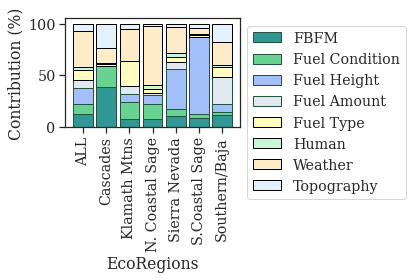

In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
  
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

r = (1, 2, 3, 4, 5, 6, 7)
# plot
barWidth = 0.85
# Create Type1
plt.bar(r, Type1, 
        color='#319795', edgecolor='#22543D', width=barWidth, 
        label="FBFM")
# Create Type2
plt.bar(r, Type2, bottom=Type1, 
        color='#68D391', edgecolor='#22543D', width=barWidth, 
        label="Fuel Condition")
# Create Type3
plt.bar(r, Type3, bottom=[i+j for i,j in zip(Type1, Type2)], 
        color='#A3BFFA', edgecolor='#22543D', width=barWidth, 
        label="Fuel Height")

# Type4 
plt.bar(r, Type4, bottom=[i+j+k for i,j,k in zip(Type1, Type2, Type3)], 
        color='#E2E8F0', edgecolor='#22543D', width=barWidth, 
        label="Fuel Amount")

# Type5
plt.bar(r, Type5, bottom=[i+j+k+l for i,j,k,l in zip(Type1, Type2, Type3, Type4)], 
        color='#FEFCBF', edgecolor='black', width=barWidth, 
        label="Fuel Type")

# Type6
plt.bar(r, Type6, bottom=[i+j+k+l+m for i,j,k,l,m in zip(Type1, Type2, Type3, Type4, Type5)], 
        color='#C6F6D5', edgecolor='black', width=barWidth, 
        label="Human")

# Type7
plt.bar(r, Type7, bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(Type1, Type2, Type3, Type4, Type5, Type6)], 
        color='#FEEBC8', edgecolor='black', width=barWidth, 
        label="Weather")

# Type7
plt.bar(r, Type8, bottom=[i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(Type1, Type2, Type3, Type4, Type5, Type6, Type7)], 
        color='#e4f1ff', edgecolor='black', width=barWidth, 
        label="Topography")


# Custom x axis
plt.xticks(r, nameList)
plt.xlabel("EcoRegions")
plt.ylabel("Contribution (%)")
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.tight_layout()
# plt.savefig(os.path.join(figOutPath, varname + "_FeatureImportance_Stacked.png"), dpi = 200)
# Show graphic

## Partial Dependence

In [ ]:
partial_dependence_df = pd.DataFrame({'EcoRegion':ecoName2,  
                             'EcoID': ecoid2,
                             'Response Variables': resVar2,
                             'Explanatory Variable': imp_var2,
                             'Rank':rank,
                             'Axes': axes_y,
                             'PDP': pdp_x})

In [ ]:
varname = 'Area'
pd_df = partial_dependence_df[partial_dependence_df['Response Variables']=='Area (ha)']

In [ ]:
varname = 'Magnitude'
pd_df = partial_dependence_df[partial_dependence_df['Response Variables']=='Magnitude (median)']

In [ ]:
ranks_list = pd_df[['EcoRegion', 'Explanatory Variable', 'Rank']].drop_duplicates()
ranks_list['Rank'] = ranks_list['Rank'].astype('int64')

In [ ]:
grp_df = ranks_list.groupby(['Explanatory Variable'])['Rank'].sum().reset_index()
grp_df = grp_df.sort_values(by='Rank')
impvars_lst = grp_df['Explanatory Variable'].tolist()

In [ ]:
['Barren',
 'Riparian',
 'Sparsely Vegetated',
 'TOPO_DIV',
 'FBFM1',
 'TreeHeight_10m',
 'TreeHeight_5m',
 'UpperSlope',
 'Ridge',
 'VegHeight_1m+',
 'VegHeight_1m',
 'Valley',
 'Hardwood',
 'travelCost',
 'Grassland',
 'TreeHeight_50m+',
 'LowerSlope',
 'FBFM8',
 'DFM100hr',
 'VegHeight_0.5m',
 'DFM1000hr',
 'FBFM7',
 'FBFM10',
 'NDMIDelta',
 'FBFM4',
 'Temp_Min',
 'Slope']

In [ ]:
impvars_lst = ['TOPO_DIV', 'FBFM1', 'Shrubland', 'Grassland'
               'Wind_Speed', 'Annual_NDVI','TreeHeight_50m+', 'VPD_Mean',
               'Grassland', 'LowerSlope']

filtdf = pd_df[pd_df['Explanatory Variable'].isin(impvars_lst)]

In [ ]:
filtdf = pd_df[(pd_df['Explanatory Variable'] ==  'TOPO_DIV') & (pd_df['EcoRegion'] == 'Sierra Nevada') | 
                                        (pd_df['Explanatory Variable'] == 'TOPO_DIV') & (pd_df['EcoRegion'] == 'Cascades') |
                                        (pd_df['Explanatory Variable'] == 'TOPO_DIV') & (pd_df['EcoRegion'] == 'Klamath Mountains') |
                                        (pd_df['Explanatory Variable'] == 'FBFM1') & (pd_df['EcoRegion'] == 'Cascades') |
                                        (pd_df['Explanatory Variable'] == 'FBFM1') & (pd_df['EcoRegion'] == 'Southern Coastal Sage') |
                                       (pd_df['Explanatory Variable'] == 'FBFM1') & (pd_df['EcoRegion'] == 'Northern Coastal Sage') |
                                        (pd_df['Explanatory Variable'] == 'Wind_Speed') & (pd_df['EcoRegion'] == 'Southern/Baja') |
                                        (pd_df['Explanatory Variable'] == 'Wind_Speed') & (pd_df['EcoRegion'] == 'Southern Coastal Sage') |
                                        (pd_df['Explanatory Variable'] == 'Wind_Speed') & (pd_df['EcoRegion'] == 'Northern Coastal Sage') |
                                        (pd_df['Explanatory Variable'] == 'Annual_NDVI') & (pd_df['EcoRegion'] == 'Northern Coastal Sage') |
                                        (pd_df['Explanatory Variable'] == 'Annual_NDVI') & (pd_df['EcoRegion'] == 'Klamath Mountains') |
                                        (pd_df['Explanatory Variable'] == 'Annual_NDVI') & (pd_df['EcoRegion'] == 'Sierra Nevada') |
                                        (pd_df['Explanatory Variable'] == 'NDMIDelta') & (pd_df['EcoRegion'] == 'Sierra Nevada') |
                                        (pd_df['Explanatory Variable'] == 'NDMIDelta') & (pd_df['EcoRegion'] == 'Southern Coastal Sage') |
                                        (pd_df['Explanatory Variable'] == 'VPD_Mean') & (pd_df['EcoRegion'] == 'Southern/Baja') |
                                        (pd_df['Explanatory Variable'] == 'VPD_Mean') & (pd_df['EcoRegion'] == 'Northern Coastal Sage') |
                                        (pd_df['Explanatory Variable'] == 'Temp_Max') & (pd_df['EcoRegion'] == 'Cascades') |
                                        (pd_df['Explanatory Variable'] == 'Temp_Max') & (pd_df['EcoRegion'] == 'Northern Coastal Sage') |
                                        (pd_df['Explanatory Variable'] == 'FFWI') & (pd_df['EcoRegion'] == 'Sierra Nevada') |
                                        (pd_df['Explanatory Variable'] == 'FFWI') & (pd_df['EcoRegion'] == 'Northern Coastal Sage') |
                                        (pd_df['Explanatory Variable'] == 'FFWI') & (pd_df['EcoRegion'] == 'Southern Coastal Sage') ]



In [ ]:
filtdf = filtdf.replace({'EcoRegion': {#'California Coastal Sage, Chaparral, and Oak Woodlands': 'CoastalSage',
 'Southern and Baja California Pine-Oak Mountains' : 'Southern/Baja'}})

In [ ]:
nameList =  [
  'Klamath Mountains',
  'Sierra Nevada',
  'Cascades', 
  'Northern Coastal Sage',
  'Southern Coastal Sage',
  'Southern/Baja']

#### Version 1

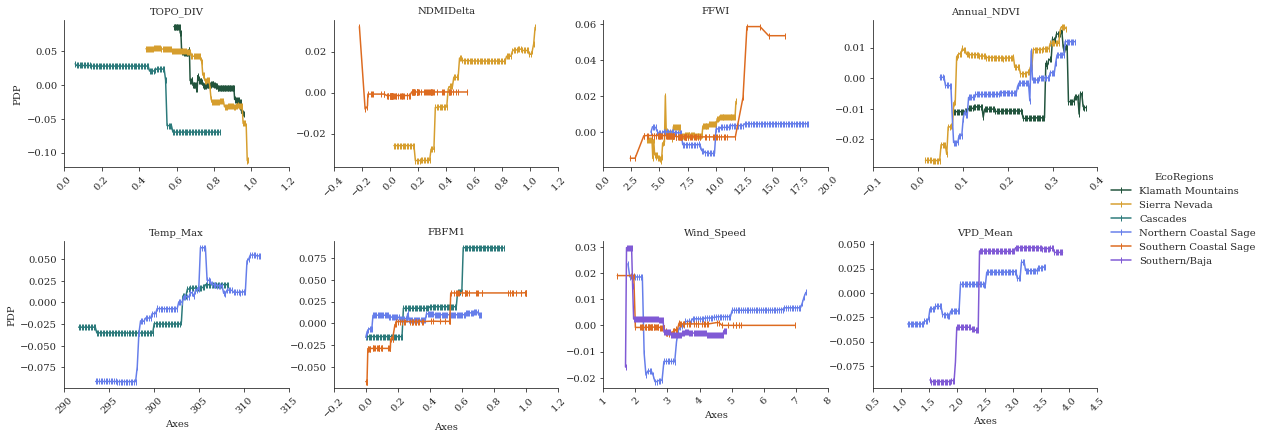

In [ ]:

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman', 'font_scale':1.4})

palette = ['#22543D', # ALL
           '#D69E2E', # 'Klamath Mountains'
           '#2C7A7B', # 'Sierra Nevada'
           '#667EEA', # 'Cascades'
           '#DD6B20', # 'California Coastal Sage, Chaparral, and Oak Woodlands'
           '#805AD5', # 'Southern and Baja California Pine-Oak Mountains'
          ]   

g = sns.FacetGrid(filtdf, hue="EcoRegion", 
                  col='Explanatory Variable', col_wrap=4,
                  sharey=False, sharex=False, aspect=1.3,
                  hue_order=nameList, 
                  palette=palette,
                  legend_out = True,
                  )
g = g.map(plt.plot, "Axes","PDP", marker="|", linewidth=1.5)
g.set_titles("{col_name}")
g.add_legend()
#plt.tight_layout()
g._legend.set_title("EcoRegions")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(hspace=0.5, wspace=0.2)
# plt.savefig(os.path.join(figOutPath, varname + "_PartialDependence.png"), dpi = 200)

In [ ]:
idx = feature_importance_df.groupby(['EcoRegion','Response Variables', 'Type'])['Score'].transform(max) == feature_importance_df['Score']
top_feature_imp = feature_importance_df[idx]

In [ ]:
top_feature_imp[top_feature_imp['Response Variables'] =='Area (ha)']

In [ ]:
top_list = top_feature_imp.groupby('EcoRegion')['Importance Variable'].apply(list)
top_list

EcoRegion
ALL                      [TreeHeight_10m, Temp_Max, TreeHeight_10m, Rip...
Cascades                 [Grassland, Ref_ET_A, Barren, Ridge, DFM100hr,...
Klamath Mountains        [TreeHeight_10m, Temp_Max, Ref_ET_A, Conifer, ...
Northern Coastal Sage    [Ref_ET_A, RH_Min, Sparsely Vegetated, TreeHei...
Sierra Nevada            [FBFM4, VegHeight_1m+, Riparian, EVI, TOPO_DIV...
Southern Coastal Sage    [TreeHeight_5m, TreeHeight_5m, DEM, DEM, DFM10...
Southern/Baja            [VegHeight_0.5m, Barren, VegHeight_0.5m, FBFM1...
Name: Importance Variable, dtype: object

In [ ]:
grouped2 = feature_importance_df.groupby(['EcoRegion','Response Variables', 'Importance Variable'])['Score'].sum().reset_index()
grouped2['Contribution (%)'] = grouped2.groupby(['EcoRegion', 'Response Variables'])['Score'].apply(lambda g: g / g.sum() * 100)

In [ ]:
grouped_area = grouped2[grouped2['Response Variables'] == 'Area (ha)']
grouped_area[grouped_area['EcoRegion'] == 'Southern Coastal Sage'].sort_values(by='Contribution (%)', ascending=False)[:20]

In [ ]:
sns.set(style="ticks", font_scale=1.2)

def createPartialPlots(df, eco):
  g = sns.FacetGrid(df, hue="EcoRegion", 
                    col='Explanatory Variable', col_wrap=2,
                    sharey=False, sharex=False, aspect=1.3,
                    palette=palette,
                    legend_out = True
                    )
  g = g.map(plt.plot, "Axes","PDP", marker="|")
  g.set_titles("{col_name}")
  g.add_legend()
  g._legend.set_title("")
  g.set_xticklabels(rotation=45)
  plt.subplots_adjust(hspace=0.5, wspace=0.2)
  if eco == 'Southern/Baja':
    plt.savefig(os.path.join(figOutPath, varname + f"_SouthernBaja_PartialDependence.png"), dpi = 200)
  else: 
    plt.savefig(os.path.join(figOutPath, varname + f"_{eco}_PartialDependence.png"), dpi = 200)

In [ ]:
for eco in ecoList: 
  filtdf = partial_dependence_df[(partial_dependence_df['EcoRegion'] == eco) & (partial_dependence_df['Explanatory Variable'].isin(top_list[5])) & 
                                                                       (partial_dependence_df['Response Variables'] == 'Area (ha)')]

  createPartialPlots(filtdf, eco)

## Decision Tree Figure

In [ ]:
pip install xgboost==1.2.0

#### Version 1

In [ ]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import to_graphviz
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from matplotlib.pylab import rcParams
from io import BytesIO

def decisionTree(res, eco):
  eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
  eco_ID = eco_df['ecoID'].iloc[0]

  X, y = eco_df[indVar], eco_df[res]
  data_dmatrix = xgb.DMatrix(data=X,label=y)

  params = {"objective":"reg:squarederror",  'learning_rate': 0.1,
                  'max_depth': 4}
            # ,'colsample_bytree': 0.3, 'alpha': 10}
  
  xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
 
  ##set up the parameters
  rcParams['figure.figsize'] = 20,10

  cNodeParams = {'shape':'box',
               'style':'filled,rounded',
               'fillcolor':'#78bceb'
              }
  lNodeParams = {'shape':'box',
                'style':'filled',
                'fillcolor':'#e48038'
                }
  xgb.to_graphviz(xg_reg, num_trees=0,\
                  condition_node_params=cNodeParams, \
                  leaf_node_params=lNodeParams,\
                  **{'size':str(15)})
  plt.savefig(os.path.join('Figures', 'Trees', f"{eco}_{res}_DecisionTree.png"), format='png', dpi = 400, bbox_inches='tight')

In [ ]:
from IPython.display import Image, display
# plotting.to_graphviz(clf,conditionNodeParams=cNodeParams,leafNodeParams=lNodeParams,**{'size':str(15)})

res = 'Area (ha)'
eco = 'Northern Coastal Sage'
decisionTree(res, eco)
# display(Image(filename=f'Figures/{eco}_{res}_DecisionTree.png'))
plt.show()

<Figure size 1440x720 with 0 Axes>

In [ ]:
eco = 'Sierra Nevada'

eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
eco_ID = eco_df['ecoID'].iloc[0]

X, y = eco_df[indVar], eco_df[res]
data_dmatrix = xgb.DMatrix(data=X,label=y)

params = {"objective":"reg:squarederror",  'learning_rate': 0.1,
                'max_depth': 4}
          # ,'colsample_bytree': 0.3, 'alpha': 10}

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

##set up the parameters
rcParams['figure.figsize'] = 15,10

cNodeParams = {'shape':'box',
              'style':'filled,rounded',
              'fillcolor':'#dafff9'
               
            }
lNodeParams = {'shape':'box',
              'style':'filled',
              'fillcolor':'#ffa500',
              }
plt.clf()
graph_to_save = xgb.to_graphviz(xg_reg,rankdir='UR', num_trees=4,\
                no_color='#841607', yes_color='#4b5f81',\
                condition_node_params=cNodeParams, \
                leaf_node_params=lNodeParams)

# plt.savefig(os.path.join('Figures', f"{eco}_{res}_DecisionTree.png"), format='png', dpi = 50, bbox_inches='tight')
graph_to_save.format = 'png'            
graph_to_save.render(os.path.join('Figures', 'Trees', f"{eco}_{res}_DecisionTree"))

'Figures/Sierra Nevada_Area (ha)_DecisionTree.png'

<Figure size 1080x720 with 0 Axes>

In [ ]:
xgb.to_graphviz(xg_reg,rankdir='UR', num_trees=4,  
                no_color='#841607', yes_color='#4b5f81',\
                condition_node_params=cNodeParams, \
                leaf_node_params=lNodeParams)

In [ ]:
! pip install graphviz

In [ ]:
! pip install pydotplus

In [ ]:
!pip install dtreeviz

In [ ]:
!pip3 install cairosvg

#### Version 2 & dtreeviz

In [ ]:
responsVar = ['Fire','JulianDay', 'Area (acre', 'Area (ha)', '(DIR_Weighted)', 'DIR_MaxDist', 'DIST_MEDSTD',
       'Magnitude (max)', 'Magnitude (median)', 'Magnitude (stdv)',
       'Magnitude (lowerQ)', 'Magnitude (upperQ)', 'Year', 'EcoRegion', 'ecoID', 'FireID']
      
topo_vars=  ['Aspect', 
            #  'Valley', 
            #  'LowerSlope', 
             'MidSlope', 
             'UpperSlope', 
            #  'Ridge',
             'DEM',
            #  'Slope', 
             'TOPO_DIV']
 
fuel_vars = ['EVI',
             'NDMI', 
             'NDMIDelta', 
             'NDVI', 
             'Annual_NDMI',
            #  'DFM1000hr',  
            #  'DFM100hr',  
            #  'Ref_ET_G',
            #  'Ref_ET_A',
            #  'Fuel_Temp_Avg',
            #  'Fuel_Moist_Per'
             '*Avg Fuel Temp (\xb0F)',
             'Fuel_Moist_Per'
             ]

fuel_amount= ['Annual_EVI', 
              'Annual_NDVI', 
              'CBD']
 
fuel_type = [
            #  'Barren', 
             'Conifer', 
             'Grassland', 
            #  'Hardwood', 
            #  'Riparian', 
             'Shrubland', 
            #  'Sparsely Vegetated'
             ]
 
FBFM_vars = [
            #  'FBFM10', 
      #        'FBFM11', 'FBFM12', 
      #        'FBFM3', 'FBFM4', 'FBFM5',
      #  'FBFM6', 'FBFM7', 
      #  'FBFM8', 'FBFM9',
       'FBFM1', 'FBFM2',  
       'FBFM6', 'FBFM7']
       
fuelHeight_vars = [
                   'TreeHeight_5m', 
                   'TreeHeight_10m', 
                   'TreeHeight_25m',
      #  'TreeHeight_50m', 
      #  'TreeHeight_50m+',  
       'VegHeight_0.5m', 
        'VegHeight_1m', 
        'VegHeight_1m+']
       
fireweather_vars = [
                    'BurningIndex', 
      #  'ERC', 
      #  'Temp_Max', 
      # #  'RH_Max', 
      #  'VPD_Mean', 
      #  'Temp_Min',  
      #  'RH_Min',
      'precip',
      #   'solar_rad',
      #    'Wind_Speed', 
         'FFWI',
         
         '*Max Wind (mph)', '*Max Temp (\xb0F)', 
        #  'Total_Solar_Rad', 
        #  'Wind_Avg_mph','Wind_Max_Avg',
        #  'Wind_Max_mph', 
        #  'Air_Temp_Max', 
        #  'Air_Temp_Avg',
          'Rel_Hum_Per',
        #   'Dew_Point_Deg','Wet_Bulb',
           'VPD'
           ]   
        
human_vars = [
              # 'travelCost'
              ]
 
indVar= topo_vars + fuel_vars + fuel_type + FBFM_vars + \
        fuelHeight_vars + fireweather_vars + human_vars + fuel_amount

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from IPython.display import Image  
import pydotplus
from sklearn import tree
from dtreeviz.trees import dtreeviz # remember to load the package
import cairosvg
import collections

def getRegressor(eco, res):
  eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
  eco_ID = eco_df['ecoID'].iloc[0]
  responsDF = eco_df[res]
  indDF = eco_df[indVar]
  sc = StandardScaler()
  X = indDF.values 
  Y = np.log10(responsDF.values)
  # call regressor
  # create a regressor object 
  regressor = DecisionTreeRegressor(max_depth=5, 
                                    max_leaf_nodes=10, 
                                    min_samples_leaf=5)  
  # fit the regressor with X and Y data 
  regressor.fit(X, Y)
  return regressor

def createDecisionTree_filled(regressor, eco, res):
  eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
  dot_data = tree.export_graphviz(regressor, out_file=None, 
                                feature_names=eco_df[indVar].columns.tolist(),  
                                filled=True, rounded=True, label = 'all')

  graph = pydotplus.graph_from_dot_data(dot_data)
  nodes = graph.get_node_list()
  for node in nodes:
    if node.get_name() not in ('edge'):
      node.set_fillcolor('#e0f4f4')

  colors =  ('#ededed', '#ffdb99')
  edges = collections.defaultdict(list)

  for edge in graph.get_edge_list():
      edges[edge.get_source()].append(int(edge.get_destination()))

  for edge in edges:
      edges[edge].sort()    
      for i in range(2):
          dest = graph.get_node(str(edges[edge][i]))[0]
          dest.set_fillcolor(colors[i])

  if eco == 'Southern/Baja':
    eco = 'SouthernBaja'

  graph.write_png(f'Figures/Trees/{eco}_{res}_tree.png')

def createDecisionTree_distribution(regressor, eco, res):
  eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
  eco_ID = eco_df['ecoID'].iloc[0]
  responsDF = eco_df[res]
  indDF = eco_df[indVar]
  sc = StandardScaler()
  X = indDF.values #sc.fit_transform(indDF.values)
  Y = responsDF.values #np.log10(responsDF.values)
  
  viz = dtreeviz(regressor, X, Y,
                target_name=f"log({res})",
                  feature_names=eco_df[indVar].columns.tolist(), 
                label_fontsize = 18, ticks_fontsize = 10, 
                fontname = 'Sans'
                )
  
  if eco == 'Southern/Baja':
    eco = 'SouthernBaja'

  viz.save(f'Figures/Trees/{eco}_{res}_dtreeviz.svg')
  cairosvg.svg2png(url=f"Figures/Trees/{eco}_{res}_dtreeviz.svg", write_to=f"Figures/Trees/{eco}_{res}_dtreeviz.png")

In [ ]:
eco_lst = ['Southern Coastal Sage', 'Northern Coastal Sage', 'Southern/Baja',\
            'Cascades', 'Sierra Nevada', 'Klamath Mountains']

res = 'Area (ha)'

for eco in eco_lst:
  regressor = getRegressor(eco, res)
  createDecisionTree_filled(regressor, eco, res)
  createDecisionTree_distribution(regressor, eco, res)

## Bivariate Regression Tree

In [ ]:
from dtreeviz.trees import *
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

def bivariatePlot(eco, res, features):
  eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
  eco_ID = eco_df['ecoID'].iloc[0]
  responsDF = eco_df[res]
  indDF = eco_df[indVar]
  sc = StandardScaler()
  X = indDF[features].values
  Y = np.log10(responsDF.values)
  # call regressor
  # create a regressor object 
  regressor = DecisionTreeRegressor(random_state =20, 
                                    max_depth=5)  
  # fit the regressor with X and Y data 
  regressor.fit(X, Y)

  t = rtreeviz_bivar_3D(regressor,
                        X, Y,
                        target_name=f'log({res})',
                        feature_names=[features[0], features[1]],
                        elev=20,
                        azim=18,
                        dist=11, 
                            )
  if eco == 'Southern/Baja':
    eco = 'SouthernBaja'

  plt.tight_layout()
  plt.savefig(os.path.join('Figures', 'bivariate', f"{eco}_{features[0]}_bivariateTree.png"), dpi = 250)
  plt.show()

<Figure size 640x480 with 0 Axes>

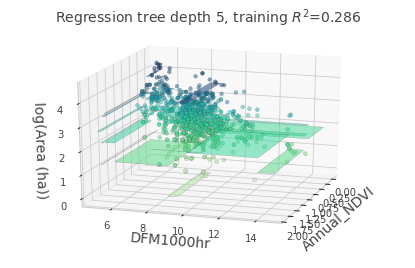

In [ ]:
eco = 'Klamath Mountains'
res = 'Area (ha)'
features=['Annual_NDVI', 'DFM1000hr']
bivariatePlot(eco, res, features)

## SHAP Visuals

#### Explainer Plot

In [ ]:
! pip install shap

In [ ]:
import xgboost
import shap
sns.set(style='ticks', rc={"grid.linewidth":1})
sns.set_context("paper", font_scale=1.5)           

# load JS visualization code to notebook
shap.initjs()

def explainerPlot(eco, res):
  shap.initjs()
  eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
  X, y = eco_df[indVar], eco_df[res]
  model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X)

  # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
  plt.clf()
  shap.force_plot(explainer.expected_value, shap_values[0,:].round(2), X.iloc[0,:].round(2), \
                  matplotlib=True, 
                  show=False, 
                  text_rotation=90,
                  plot_cmap='RgBu', figsize=(10, 3))

  plt.ylabel(eco,fontsize=20) #.set_position([0, 0])

  if eco == 'Southern/Baja':
    eco = 'Southern_Baja'
    plt.savefig(os.path.join('Figures', f"{eco}_TreeExplainer.png"), format='png', dpi = 400, bbox_inches='tight')
    
  else: 
    plt.savefig(os.path.join('Figures', f"{eco}_TreeExplainer.png"), format='png', dpi = 400, bbox_inches='tight')

In [ ]:
explainerPlot('Sierra Nevada', 'Area (ha)')
explainerPlot('Cascades', 'Area (ha)')
explainerPlot('Klamath Mountains', 'Area (ha)')
explainerPlot('Northern Coastal Sage', 'Area (ha)')
explainerPlot('Southern Coastal Sage', 'Area (ha)')
explainerPlot('Southern/Baja', 'Area (ha)')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import sys
from PIL import Image, ImageOps

In [ ]:
def get_concat_v(images):
  widths, heights = zip(*(i.size for i in images))

  total_width = max(widths)
  max_height = sum(heights)
  new_im = Image.new('RGB', (total_width, max_height))

  y_offset = 0
  for im in images: 
    new_im.paste(im, (0,y_offset))
    y_offset += im.size[1]

  new_im.info["dpi"] = 200
  new_im.save(os.path.join('Figures', f"Combined_TreeExplainer.png"))


In [ ]:
images = [Image.open(x) for x in [os.path.join('Figures', f"Sierra Nevada_TreeExplainer.png"), 
                                  os.path.join('Figures', f"Southern_Baja_TreeExplainer.png"), 
                                  os.path.join('Figures', f"Northern Coastal Sage_TreeExplainer.png"),
                                  os.path.join('Figures', f"Southern Coastal Sage_TreeExplainer.png"),
                                  os.path.join('Figures', f"Cascades_TreeExplainer.png"),
                                  os.path.join('Figures', f"Klamath Mountains_TreeExplainer.png")]]

In [ ]:
get_concat_v(images)

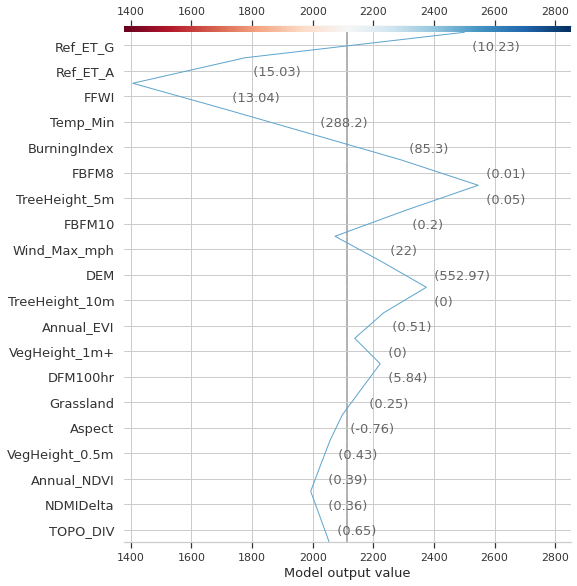

In [ ]:
eco_df = facet_data[(facet_data['EcoRegion'] == 'Northern Coastal Sage')]
X, y = eco_df[indVar], eco_df[res]
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X)

shap.decision_plot(expected_value, 
                   shap_values[0,:].round(2), 
                   X.iloc[0,:].round(2), 
                   plot_color='RdBu', link='identity',  
                   y_demarc_color='#fffff3')

## Multi-Dependence Plot

##### ALL

In [ ]:
! pip install shap

In [ ]:
import xgboost
import shap
sns.set(style='whitegrid', rc={"grid.linewidth":1})
sns.set_context("paper", font_scale=1.5)   

def dependencePlots(res, eco, Var1, Var2, xlabel_string):
  eco_df = facet_data[(facet_data['EcoRegion'] == eco)]
  X, y = eco_df[indVar], np.log(eco_df[res])
  model = xgboost.train({"learning_rate": 0.1}, xgboost.DMatrix(X, label=y), 100)

  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X)
  plt.clf()
  shap.dependence_plot(Var1, shap_values, X, interaction_index=Var2, \
                      cmap='RdBu_r', show=False, dot_size=120, alpha=0.9,
                       #xmin=5, #xmax=0.01
                       
                       ) 
  
  if eco == 'Southern/Baja':
    eco = 'Southern Baja'
  plt.xlabel(xlabel_string, fontsize=16)
  plt.ylabel('Additive Explanations (SHAP)', fontsize=16)
  plt.title(eco, fontsize=20)
  plt.savefig(os.path.join('Figures', f"{eco}_{Var1}_{Var2}_PartialDep.png"), format='png', \
              dpi = 400, bbox_inches='tight')
  return plt.show()

<Figure size 432x288 with 0 Axes>

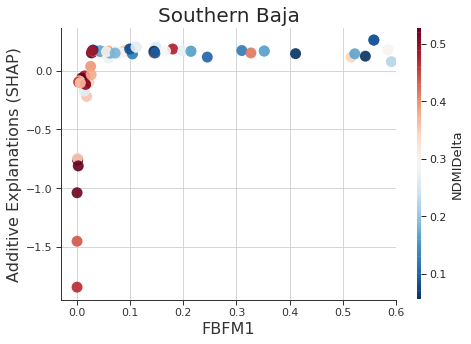

In [ ]:
# [RAWS]'Avg Fuel Temp (\xb0F)',
dependencePlots('Area (ha)', 'Southern/Baja', 'FBFM1', 'NDMIDelta', 'FBFM1')

##### Cascades

<Figure size 432x288 with 0 Axes>

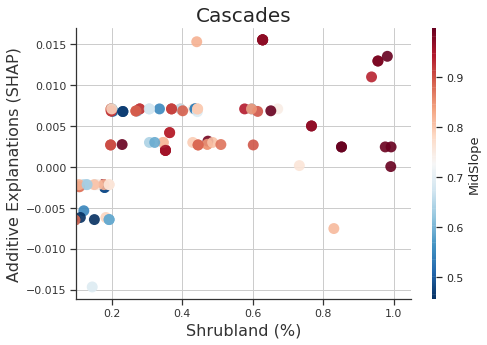

In [ ]:
sns.set(style="whitegrid")
dependencePlots('Magnitude (upperQ)', 'Cascades', 'Shrubland', 'MidSlope', 'Shrubland (%)')

##### Sierra Nevada

<Figure size 432x288 with 0 Axes>

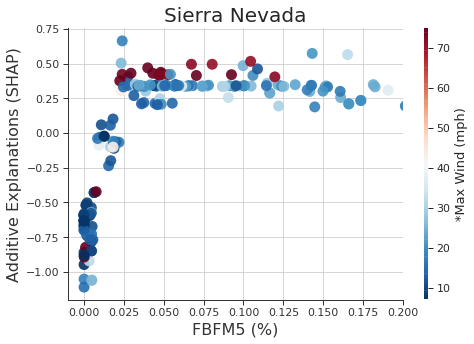

In [ ]:
# [RAWS]
dependencePlots('Area (ha)', 'Sierra Nevada', 'FBFM5', '*Max Wind (mph)', 'FBFM5 (%)')

##### Northern Coastal Sage

In [ ]:
facet_data.columns.tolist()

In [ ]:
# [RAWS]
sns.set(style="whitegrid", font_scale=20)
dependencePlots('Area (ha)', 'Northern Coastal Sage', '*Max Wind (mph)', 'Annual_NDVI', \
                '*Max Wind (mph)')

##### Southern Coastal Sage

In [ ]:
sns.set(style="whitegrid")
dependencePlots('Area (ha)', 'Southern Coastal Sage', 'TreeHeight_5m', '*Max Wind (mph)', 'TreeHeight_5m')

##### Klamath Mountains

<Figure size 432x288 with 0 Axes>

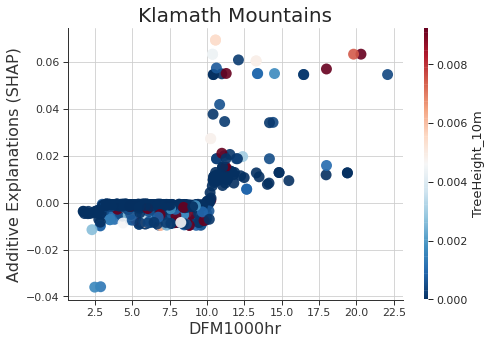

In [ ]:
#[RAWS]
dependencePlots('Area (ha)', 'Klamath Mountains', 'FFWI', 'TreeHeight_10m', 'DFM1000hr')

In [ ]:
eco = 'Northern Coastal Sage'
res = 'Magnitude (upperQ)'

explainerPlot(eco, res)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:].round(2), X.iloc[0,:].round(2), \
                  matplotlib=True, show=False, plot_cmap=["#FF5733","#FFFF33"])

## Summary Stats 

### Fire Size relation with weather vars

In [ ]:
facet_data['Size'] = np.where(facet_data['Area (ha)'] < facet_data['Area (ha)'].quantile(0.25), 'Small', 
         (np.where(facet_data['Area (ha)'] < facet_data['Area (ha)'].quantile(0.45), 'Medium', 
                   np.where(facet_data['Area (ha)'] < facet_data['Area (ha)'].quantile(0.75), 'Large','Extreme'))))
                            # np.where(facet_data['Area (ha)'] < facet_data['Area (ha)'].quantile(0.90), 'Very Large','Extreme')))))

No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

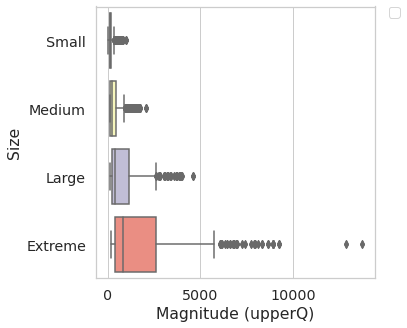

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib.pyplot import figure
ax = sns.boxplot(x="Magnitude (upperQ)", y="Size", orient='h',# hue='EcoRegion',
                 data=facet_data, palette="Set3", order=['Small', 'Medium', 'Large', 'Extreme'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

In [ ]:
# bio/climate
bioInfo = facet_data.groupby(['EcoRegion', 'Size']).agg({
    'VPD_Mean': ['median', 'mad'],
    'Temp_Max': ['median', 'mad'],
    'Wind_Speed': ['median', 'mad']}).reset_index().round(2)

In [ ]:
bioInfo.columns = ['EcoRegion', 'Size', 'VPD_Med', 'VPD_Std', 
                   'Temp_Med', 'Temp_Std', 'Wind_Med', 'Wind_Std']

In [ ]:
bioInfo = bioInfo.astype('str')
bioInfo = bioInfo[bioInfo['EcoRegion'] != 'ALL']

In [ ]:
bioInfo['VPD'] = bioInfo[['VPD_Med', 'VPD_Std']].apply(lambda x: ' ± '.join(x[x.notnull()]), axis = 1)
bioInfo['Temp'] = bioInfo[['Temp_Med', 'Temp_Std']].apply(lambda x: ' ± '.join(x[x.notnull()]), axis = 1)
bioInfo['Wind'] = bioInfo[['Wind_Med', 'Wind_Std']].apply(lambda x: ' ± '.join(x[x.notnull()]), axis = 1)
bioInfo = bioInfo[['EcoRegion', 'Size', 'Temp', 'VPD', 'Wind']]

In [ ]:
bioInfo.pivot

bioInfo.pivot(index='Size', columns='EcoRegion', values=['VPD', 'Temp', 'Wind'])

VPD                    ...                  Wind              
EcoRegion      Cascades Klamath Mountains  ... Southern Coastal Sage Southern/Baja
Size                                       ...                                    
Extreme     2.46 ± 0.49       2.55 ± 0.47  ...           2.64 ± 0.66    3.64 ± 0.7
Large       2.25 ± 0.45       1.87 ± 0.54  ...           3.07 ± 0.83   2.78 ± 0.78
Medium       1.87 ± 0.4       1.73 ± 0.56  ...            2.7 ± 0.23   3.07 ± 0.89
Small       1.47 ± 0.42       1.57 ± 0.44  ...           2.85 ± 0.57   2.93 ± 0.82
Very Large   2.3 ± 0.44       2.11 ± 0.46  ...           3.28 ± 0.82    3.1 ± 0.66

[5 rows x 18 columns]

### Violin Plot Extreme vs Small fires

In [ ]:
viollin_data = facet_data[['Size', 'EcoRegion', 'VPD_Mean', 'Shrubland', 
                           'Conifer', 'Magnitude (upperQ)',
                           'Temp_Max', 'DFM100hr', 'VegHeight_1m']]
viollin_data = viollin_data.reset_index().drop(columns=['level_0', 'level_1'])
viollin_data['Magnitude (upperQ)'] = np.log(viollin_data['Magnitude (upperQ)'] / 1000)

In [ ]:
melted_df = pd.melt(viollin_data, 
                    id_vars=['Size', 'EcoRegion'], 
                    value_vars=['Shrubland', 'Conifer', 'Magnitude (upperQ)',#Wind_Max_Avg','FBFM1',
                                'VPD_Mean', 'Temp_Max', 
                                 'DFM100hr'],
        var_name='Variable', value_name='Value')

In [ ]:
melted_df = melted_df.replace({'VPD_Mean': 'Vapor Pressure Deficit \n (kPa)', 
                               'Temp_Max': 'Max Temperature \n (K)', 
                   'DFM100hr': 'Dead Fuel Moisture \n (%)', 'Shrubland': 'Shrubland \n (%)'})

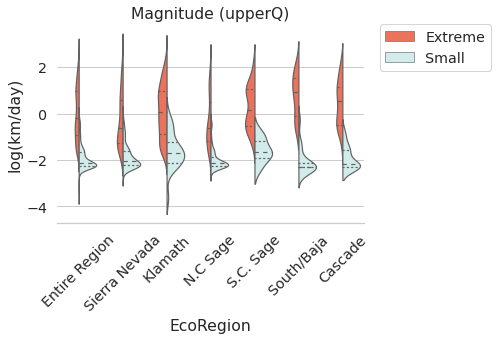

In [ ]:
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set(style = 'whitegrid', font_scale=1.3)

sm_lrg = melted_df[(melted_df['Size'] == 'Small') | (melted_df['Size'] == 'Extreme')]

# Draw a nested violinplot and split the violins for easier comparison
g = sns.catplot(data=sm_lrg, x="EcoRegion", y="Value", hue="Size", col= 'Variable', col_wrap=2,
               split=True, inner="quartile", linewidth=1.2, kind='violin',legend=False, 
                col_order=[ 'Magnitude (upperQ)',
                          #  'Vapor Pressure Deficit \n (kPa)', 
                          #  'Max Temperature \n (K)',
                          #  'Dead Fuel Moisture \n (%)', 
                          #  'Shrubland \n (%)'
                           ], 
               palette={"Extreme": "#eb725c", "Small": "#d2ecec"}, sharey=False, saturation=1)
sns.despine(left=True)

g.set_xticklabels(['Entire Region', 'Sierra Nevada', 'Klamath', 'N.C Sage', 'S.C. Sage', 'South/Baja', 'Cascade'], rotation=45)
# g.set_ylabel('VPD', fontsize=15)
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.ylabel('log(km/day)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join('Figures', "Magnitude_Distribution_Violin.png"), dpi = 200)

### Top 75 percentile

In [ ]:
# get largest fires 
Top25_area_val = facet_data['Area (ha)'].quantile(0.75)
top25_area = facet_data[facet_data['Area (ha)'] >= Top25_area_val].reset_index()

In [ ]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [ ]:
# Area & Magnitude 
areaInfo=top25_area.groupby(["EcoRegion"])["Area (ha)"].sum()
area_med=top25_area.groupby(["EcoRegion"])["Area (ha)"].median()
#areaInfo['Area (ha)'] = areaInfo['Area (ha)'] / 1000

mag_med = top25_area.groupby(["EcoRegion"])["Magnitude (median)"].median()
mad_upper = top25_area.groupby(["EcoRegion"])["Magnitude (median)"].quantile(q=0.75)
mad_lower = top25_area.groupby(["EcoRegion"])["Magnitude (median)"].quantile(q=0.25)

In [ ]:
magInfo = pd.DataFrame(data=dict(s1 = areaInfo, s2 = area_med, s3=mag_med, s4=mad_upper, s5=mad_lower))
magInfo.columns = ["Total Area (ha)", "Median Area",
                   "Median","Median(UpperQ)", 'Median(LowerQ)']
magInfo

,Total Area (ha),Median Area,Median,Median(UpperQ),Median(LowerQ)
EcoRegion,,,,,
ALL,3.058258e+06,2741.086896,226.3100,1057.32100,132.20900
Cascades,3.996984e+05,2683.159421,340.4920,1057.32100,165.58100
Klamath Mountains,7.091939e+05,2829.842288,181.3715,399.07350,127.69275
Northern Coastal Sage,1.202630e+06,2904.011781,301.4840,1157.55950,134.20450
Sierra Nevada,4.687805e+05,2236.314935,149.3405,534.28075,113.56825
Southern Coastal Sage,1.139231e+05,2958.854938,1581.8740,2825.30200,308.16200
Southern/Baja,1.640314e+05,2545.689445,578.5275,2180.28375,162.14075


In [ ]:
top25_area.columns.tolist()

In [ ]:
# bio/climate
top25_area['travelCost'] = top25_area['travelCost'] / 1000
bioInfo = top25_area.groupby('EcoRegion').agg({
    'DEM': ['median', 'mad'], 
    'Annual_NDVI': ['median', 'mad'],
    'VPD': ['median', 'mad'],
    'CBD': ['median', 'mad'],
    'Air_Temp_Max': ['median', 'mad'],
    'Wind_Max_Avg': ['median', 'mad']}).reset_index()
bioInfo = bioInfo.set_index('EcoRegion')
bioInfo = bioInfo.reindex(['Klamath Mountains', 'Sierra Nevada','Northern Coastal Sage', 'Southern Coastal Sage', #California Coastal Sage, Chaparral, and Oak Woodlands',
                    'Cascades','Southern/Baja','ALL'])
bioInfo

### % of total BA during the first two days

In [ ]:
fire_info = facet_data[['FireID', 'EcoRegion', 'Date', 'Area (ha)']]
fire_info = fire_info.sort_values(by=['FireID', 'Date'])
first_two_df = fire_info.groupby('FireID').head(2).reset_index(drop=True)
first_two_df_sum = first_two_df.groupby(['FireID', 'EcoRegion']).agg({'Area (ha)' : ['sum']}).reset_index()
first_two_df_sum.columns = ['FireID', 'EcoRegion', 'First_Two_Sum']
first_two_df_sum

In [ ]:
total_fire = facet_data[['FireID', 'Area (ha)', 'EcoRegion']]
total_fire_sum = total_fire.groupby(['FireID', 'EcoRegion']).agg({'Area (ha)' : ['sum']}).reset_index()
total_fire_sum.columns = ['FireID', 'EcoRegion', 'Total Area (ha)']
total_fire_sum

In [ ]:
g = sns.swarmplot(x = 'EcoRegion', y = 'TwoDayPercent',
            data = merged_2day_sum, )
g = sns.boxplot(x = 'EcoRegion', y = 'TwoDayPercent',
            data = merged_2day_sum, )
g.set_xticklabels(['Entire Region', 'Sierra Nevada', 'N.C Sage', 'Klamath','S.C. Sage', 'Cascade', 'South/Baja'], rotation=45)

In [ ]:
merged_2day_sum = first_two_df_sum.merge(total_fire_sum, on=['FireID','EcoRegion'])
merged_2day_sum['TwoDayPercent'] = (merged_2day_sum['First_Two_Sum'] / merged_2day_sum['Total Area (ha)']) * 100

In [ ]:
merged_2day_sum

merged_2day_sum_ECO = merged_2day_sum.groupby(['EcoRegion'])
merged_2day_sum_ECO = merged_2day_sum_ECO.agg({'TwoDayPercent' : ['median', percentile(25), percentile(75)],
                        }).round(2).reset_index()

merged_2day_sum_ECO.columns = ['EcoRegion', 'TwoDay_Median', 
                               'TwoDay_lower', 'TwoDay_upper']

In [ ]:
merged_2day_sum_ECO = merged_2day_sum_ECO.astype('str')
merged_2day_sum_ECO['TwoDay_IQR'] = merged_2day_sum_ECO[['TwoDay_lower', 'TwoDay_upper']].apply(lambda x: ' ± '.join(x[x.notnull()]), axis = 1)

merged_2day_sum_ECO = merged_2day_sum_ECO[['EcoRegion', 'TwoDay_Median', 'TwoDay_IQR']]

In [ ]:
merged_2day_sum_ECO

,EcoRegion,TwoDay_Median,TwoDay_IQR
0,ALL,32.66,7.16 ± 100.0
1,Cascades,30.5,6.96 ± 100.0
2,Klamath Mountains,11.53,4.75 ± 38.5
3,Northern Coastal Sage,77.63,21.56 ± 100.0
4,Sierra Nevada,15.19,3.55 ± 42.81
5,Southern Coastal Sage,100.0,40.12 ± 100.0
6,Southern/Baja,32.48,7.77 ± 96.58


### How long to reach 75% of total BA

#### By Year

In [ ]:
# facet_data = facet_data.sort_values(by=['Fire', 'Date', 'Year']).reset_index()
fire_info = gridmet_2012_2020[['FireID', 'Date', 'Area (ha)']]
fire_info = fire_info.drop_duplicates()
fire_info['Year'] = pd.DatetimeIndex(fire_info['Date']).year

In [ ]:
fireCount = fire_info.groupby(['FireID', 'Year'])
cumudf = fireCount.agg({'Date' : ['count'] , 'Area (ha)' : ['sum']}).reset_index()
cumudf.columns = ['FireID', 'Year', 'Original Total Days', 'Original Total Area']

# calculate percent cumulative burn 
newDF = fire_info.merge(cumudf, on=['FireID', 'Year'])
newDF['Ratio'] = newDF['Area (ha)']  / newDF['Original Total Area'] 
newDF['cumsum'] = newDF.groupby(['FireID', 'Year'])['Ratio'].cumsum() 

In [ ]:
Top_BA_75 = newDF[(newDF['cumsum'] >= .75)] # & (newDF['Original Total Area'] >= 2000)]
Top_BA_75_count = Top_BA_75.groupby(['FireID', 'Year', 'Original Total Days'])['Date'].count().reset_index()

In [ ]:
Top_BA_75_count['DaysUntil75'] = Top_BA_75_count['Original Total Days'] - (Top_BA_75_count['Date']-1)

In [ ]:
Top_BA_75_count['Spread to 75%'] = np.where(Top_BA_75_count['DaysUntil75']<=2, '1-2 Days', 
                                    np.where(Top_BA_75_count['DaysUntil75']<=4, '3-4 Days', 
                                             np.where(Top_BA_75_count['DaysUntil75']<=6, '5-6 Days', f'$\geq$7 Days')))

In [ ]:
dfm_100hr = newDF[['Area (ha)', 'Year']]

dfm_100hr = dfm_100hr.groupby(['Year']).agg({'Area (ha)' : ['sum']}).reset_index()
dfm_100hr.columns = ['Year', 'Area (ha)']
dfm_100hr['Area (ha) * 10^5'] = dfm_100hr['Area (ha)'] /1000000

In [ ]:
annual_count = Top_BA_75_count.groupby(['Year', 'Spread to 75%']).agg({'FireID' : ['count']}).reset_index()
annual_count.columns = ['Year', 'Spread to 75%', 'Count']

annual_count = annual_count.set_index('Year').fillna(0)
annual_count_piv = annual_count.pivot(columns='Spread to 75%', values='Count')

In [ ]:
annual_count_piv = annual_count_piv[['1-2 Days', '3-4 Days', '5-6 Days', '$\geq$7 Days']]
annual_count_piv

Spread to 75%,1-2 Days,3-4 Days,5-6 Days,$\geq$7 Days
Year,,,,
2012,28,13,5,10
2013,21,7,3,7
2014,21,6,5,13
2015,16,10,10,33
2016,21,14,5,8
2017,40,12,6,34
2018,26,6,7,16
2019,23,6,3,5
2020,11,11,6,32


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
flatui = ["#e33617","#ea6d09", '#fabb01', "#80cbc9"]
sns.set_palette(flatui)

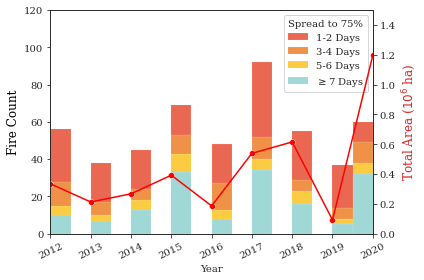

In [ ]:

plot_options = {'labelrotation':25}
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax1 = sns.histplot(
    Top_BA_75_count,
    x="Year", hue='Spread to 75%',
    hue_order = ['1-2 Days', '3-4 Days', '5-6 Days', '$\geq$7 Days'],
    multiple="stack",
    # palette=flatui,
    edgecolor="1",
    linewidth=0.1, 
    legend=True, 
    binwidth = 0.5,
    # cumulative=True 
    )


ax1.set_ylabel('Fire Count', fontsize=12, color='black')
# ax1.set_xlim(2011,2021)
ax1.set_ylim(0,120)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Total Area ($10^6$ ha)", fontsize=12, color=color)
ax2 = sns.lineplot(data = dfm_100hr, x="Year", y='Area (ha) * 10^5',
                   markers=True, legend=False, color='red', sort=True, linewidth = 1.5)
ax2 = sns.scatterplot(data = dfm_100hr, x="Year", y='Area (ha) * 10^5',
                   markers=True, legend=False, color='red')
ax2.set_ylim(0,1.5)

ax2.set_xlim(2012,2020)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .2)

ax1.set_xticklabels(['2012', '2013', '2014', '2015', '2016', '2017', \
                     '2018' , '2019', '2020'], rotation=25)
# change_width(ax1, .6)
plt.tight_layout()
plt.savefig(os.path.join('Figures', "DaysToReach75Area.png"), dpi = 200)

In [ ]:
fire_info_df['Area (ha)'] = fire_info_df.geometry.area * 0.0002471054 * 0.404686

In [ ]:
fire_info_df['EcoID'] = fire_info_df['ecoID'].iloc[:, 1]

In [ ]:
fire_info = fire_info_df[['Fire', 'Date', 'EcoID', 'Area (ha)']]
fire_info = fire_info.drop_duplicates()
fire_info['Year'] = pd.DatetimeIndex(fire_info['Date']).year

In [ ]:
fire_info

,Fire,Date,EcoID,Area (ha),Year
0,Myers,2020-08-19,0,707.577534,2020
1,Myers,2020-08-20,0,21.444504,2020
2,Myers,2020-08-21,0,3.701365,2020
3,Walbridge,2020-08-18,0,11.307919,2020
4,Walbridge,2020-08-19,0,5829.115246,2020
...,...,...,...,...,...
5494,Draper,2017-09-14,10,9.476211,2017
5495,Lincoln,2019-03-15,10,87.176843,2019
5496,Lincoln,2019-03-16,10,23.882511,2019
5497,Lincoln,2019-03-17,10,16.700075,2019


In [ ]:
totalarea_byfire = fire_info.groupby(['Year', 'Fire', 'EcoID']).agg({'Area (ha)' : ['sum']}).reset_index()

In [ ]:
totalarea_byfire.columns = ['Year', 'Fire', 'EcoID', 'Total Area (ha)']

In [ ]:
totalarea_byfire

,Year,Fire,EcoID,Total Area (ha)
0,2012,16,5,7196.863063
1,2012,Antelope,12,213.740859
2,2012,Bagley,7,18324.169690
3,2012,Banner,8,726.575642
4,2012,Banner,10,1054.701257
...,...,...,...,...
600,2020,Wolf,4,760.317126
601,2020,Woodward,0,1917.482950
602,2020,Woodward,5,8.143260
603,2020,Zogg,5,17965.472463


In [ ]:
totalarea_byfire['2020_Boolean'] = np.where(totalarea_byfire['Year'] < 2016, '2012-2015', 
                                            np.where(totalarea_byfire['Year'] < 2019, '2016-2019','2020')) 

In [ ]:
totalarea_byfire.loc[totalarea_byfire.EcoID == 5, 'EcoID'] = "Northern Coastal Sage"
totalarea_byfire.loc[totalarea_byfire.EcoID == 11, 'EcoID'] = "Southern Coastal Sage"
totalarea_byfire.loc[totalarea_byfire.EcoID == 8, 'EcoID'] = "Southern/Baja"
totalarea_byfire.loc[totalarea_byfire.EcoID == 2, 'EcoID'] = "Southern/Baja"
totalarea_byfire.loc[totalarea_byfire.EcoID == 1, 'EcoID'] = "Northern Coastal Sage"
totalarea_byfire.loc[totalarea_byfire.EcoID == 6, 'EcoID'] = "Northern Coastal Sage"
totalarea_byfire.loc[totalarea_byfire.EcoID == 0, 'EcoID'] = "Klamath Mountains"
totalarea_byfire.loc[totalarea_byfire.EcoID == 7, 'EcoID'] = "Klamath Mountains"
totalarea_byfire.loc[totalarea_byfire.EcoID == 3, 'EcoID'] = "Cascades"
totalarea_byfire.loc[totalarea_byfire.EcoID == 12, 'EcoID'] = "Cascades"
totalarea_byfire.loc[totalarea_byfire.EcoID == 4, 'EcoID'] = "Sierra Nevada"

In [ ]:
totalarea_byfire.EcoID.unique()

array(['Northern Coastal Sage', 'Cascades', 'Klamath Mountains',
       'Southern/Baja', 10, 'Sierra Nevada', 'Southern Coastal Sage', 9],
      dtype=object)

In [ ]:
eco_hue_list = ['Cascades', 'Klamath Mountains', 'Northern Coastal Sage', 'Sierra Nevada', 'Southern Coastal Sage', 'Southern/Baja']

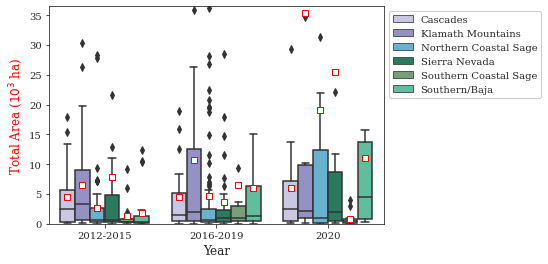

In [ ]:
flatui2 = ['#bebbed', '#7e78dc', '#35ccff', '#05a167', '#66b266', '#32ecab']
pal2 = sns.set_palette(sns.color_palette(flatui2))

plot_options = {'labelrotation':25}
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

# fig, ax1 = plt.subplots(figsize=(8,6))

totalarea_byfire['log_area'] = np.log(totalarea_byfire['Total Area (ha)'])
totalarea_byfire['Total Area (ha) 10^3'] = totalarea_byfire['Total Area (ha)'] / 1000 

ax1 = sns.boxplot(
    data = totalarea_byfire,
    x="2020_Boolean", y = 'Total Area (ha) 10^3' , hue = 'EcoID',
    hue_order = eco_hue_list, width = 0.8, saturation = 0.5,
    showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"red"})

ax1.set_ylabel("Total Area ($10^3$ ha)", fontsize=12, color='red')
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylim(0,36.5)

ax1.legend(bbox_to_anchor=(1, 1), framealpha=1)
# plt.tight_layout()
plt.savefig(os.path.join('Figures', "Annual_Area.png"), dpi = 200)

#### By Region

In [ ]:
# summarize subregion

In [ ]:
# facet_data = facet_data.sort_values(by=['Fire', 'Date', 'Year']).reset_index()
fire_info = facet_data[['Year','Fire', 'Date', 'Area (ha)', 'EcoRegion']]
fire_info = fire_info.drop_duplicates()

In [ ]:
fireCount = spreadFile.groupby(['Year', 'Fire', 'EcoRegion'])
cumudf = fireCount.agg({'Date' : ['count'] , 'Area (ha)' : ['sum']}).reset_index()
cumudf.columns = ['Year','Fire', 'EcoRegion', 'Original Total Days', 'Original Total Area']

# calculate percent cumulative burn 
newDF = fire_info.merge(cumudf, on=['Year','Fire', 'EcoRegion'])
newDF['Ratio'] = newDF['Area (ha)']  / newDF['Original Total Area'] 
newDF['cumsum'] = newDF.groupby(['Year','Fire', 'EcoRegion'])['Ratio'].cumsum() 

In [ ]:
Top_BA_75 = newDF[(newDF['cumsum'] >= .75)] # & (newDF['Original Total Area'] >= 2000)]
Top_BA_75_count = Top_BA_75.groupby(['Fire', 'EcoRegion', 'Original Total Days'])['Date'].count().reset_index()

In [ ]:
Top_BA_75_count['DaysUntil75'] = Top_BA_75_count['Original Total Days'] - (Top_BA_75_count['Date']-1)

In [ ]:
Top_BA_75_count['Spread to 75%'] = np.where(Top_BA_75_count['DaysUntil75']<=2, '1-2 Days', 
                                    np.where(Top_BA_75_count['DaysUntil75']<=4, '3-4 Days', 
                                             np.where(Top_BA_75_count['DaysUntil75']<=6, '5-6 Days', f'$\geq$7 Days')))

In [ ]:
Top_BA_75_count

state_office = Top_BA_75_count.groupby(['EcoRegion', 'Spread to 75%']).agg({'Fire': 'count'})
# Change: groupby state_office and divide by sum
state_pcts = state_office.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [ ]:
counted_Top_BA = Top_BA_75_count.groupby(['EcoRegion', 'Spread to 75%'])['Fire'].count().reset_index()

In [ ]:
ecoreg_list = list(Top_BA_75_count['EcoRegion'].unique())
ecoreg_list

['Northern Coastal Sage',
 'Klamath Mountains',
 'Sierra Nevada',
 'Cascades',
 'Southern Coastal Sage',
 'Southern/Baja']

In [ ]:
fire_info

FireID              EcoRegion        Date    Area (ha)
Fire 0        1.0                    ALL  2018-07-13   107.478110
Date 0        1.0          Sierra Nevada  2018-07-13   107.478110
Fire 1        1.0                    ALL  2018-07-14  2639.634510
Date 1        1.0          Sierra Nevada  2018-07-14  2639.634510
Fire 2        1.0                    ALL  2018-07-15  3643.309397
...           ...                    ...         ...          ...
Date 4690   500.0  Northern Coastal Sage  2020-08-29  3260.390950
Fire 4693   500.0                    ALL  2020-08-31  6822.926898
     4694   500.0                    ALL  2020-08-31  6822.926898
Date 4693   500.0      Klamath Mountains  2020-08-31  6822.926898
     4694   500.0  Northern Coastal Sage  2020-08-31  6822.926898

[4932 rows x 4 columns]

In [ ]:
dfm_100hr = newDF[['Area (ha)', 'EcoRegion']]

dfm_100hr[dfm_100hr['EcoRegion'].isin(ecoreg_list)]

dfm_100hr = dfm_100hr.groupby(['EcoRegion']).agg({'Area (ha)' : ['sum']}).reset_index()
dfm_100hr.columns = ['EcoRegion', 'Area (ha)']
dfm_100hr['Area (ha) * 10^6'] = dfm_100hr['Area (ha)'] /1000

dfm_100hr

,EcoRegion,Area (ha),Area (ha) * 10^6
0,Cascades,3.181100e+05,318.110014
1,Klamath Mountains,8.679233e+05,867.923327
2,Northern Coastal Sage,1.198916e+06,1198.915604
3,Sierra Nevada,5.595641e+05,559.564143
4,Southern Coastal Sage,1.342106e+05,134.210626
5,Southern/Baja,1.607304e+05,160.730402


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
flatui = ["#e33617","#ea6d09", '#fabb01', "#80cbc9"]
sns.set_palette(flatui)

In [ ]:
dfm_100hr

,EcoRegion,Area (ha),Area (ha) * 10^5
0,Cascades,3.181100e+05,0.318110
1,Klamath Mountains,8.679233e+05,0.867923
2,Northern Coastal Sage,1.198916e+06,1.198916
3,Sierra Nevada,5.595641e+05,0.559564
4,Southern Coastal Sage,1.342106e+05,0.134211
5,Southern/Baja,1.607304e+05,0.160730


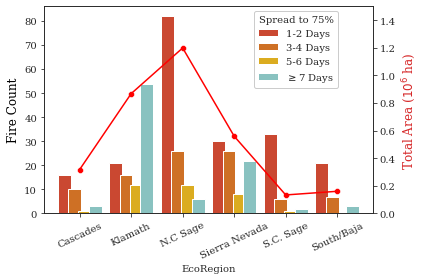

In [ ]:

plot_options = {'labelrotation':25}
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

# fig, ax1 = plt.subplots(figsize=(10,6))


ax1 = sns.barplot(x="EcoRegion", y="Fire", 
                  hue= 'Spread to 75%', 
                  hue_order = ['1-2 Days', '3-4 Days', '5-6 Days', '$\geq$7 Days'],
                  data=counted_Top_BA)

ax1.set_ylabel('Fire Count', fontsize=12, color='black')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Total Area ($10^6$ ha)", fontsize=12, color=color)
ax2 = sns.lineplot(data = dfm_100hr, 
                   x="EcoRegion", y='Area (ha) * 10^5',
                   markers=True, legend=True, 
                   color='red', sort=True, linewidth = 1.5)
ax2 = sns.scatterplot(data = dfm_100hr, x="EcoRegion", y='Area (ha) * 10^5',
                   markers=True, legend=False, color='red')
ax2.set_ylim(0,1.5)

ax1.set_xticklabels(['Cascades', 'Klamath', 'N.C Sage', 'Sierra Nevada', 'S.C. Sage', 'South/Baja'], rotation=25)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .25)

ax1.legend(bbox_to_anchor=(0.91, 1), framealpha=1,  title="Spread to 75%",)

plt.tight_layout()
plt.savefig(os.path.join('Figures', "DaysToReach75Area_ByRegion.png"), dpi = 200)

### Summary of Fire Spread Stats (Table1)

- By Ecoregion 
- Count, Days 
- Fire Size (Median, Quantiles) 
- Rate of Spread (Median, Quantiles) 
- Num. of days to reach 75% (Median, Quantile) 

In [ ]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:
fire_spread_df = facet_data[['Fire', 'Date', 'EcoRegion', 'Area (ha)', 'Magnitude (upperQ)']]
fire_spread_df['Area (ha)'] = fire_spread_df['Area (ha)'] /1000
fire_spread_df['Magnitude (upperQ)'] = fire_spread_df['Magnitude (upperQ)'] /1000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
fireCount = fire_spread_df.groupby(['Fire', 'EcoRegion'])
fire_info = fireCount.agg({'Date' : ['count'] , 
                        'Area (ha)' : ['sum'],
                        'Magnitude (upperQ)' : ['max'],
                        }).round(2).reset_index()
fire_info.columns = ['FireID', 'EcoRegion', 'Total Days', 'Total Area', 'Max Magnitude']

In [ ]:
byeco_count = fire_info.groupby(['EcoRegion'])
byeco_info = byeco_count.agg({'FireID' : ['count'] , 
                              'Total Days' : ['sum'] , 
                        'Total Area' : ['median', percentile(25), percentile(75)],
                        'Max Magnitude' : ['median', percentile(25), percentile(75)],
                        }).round(2).reset_index()

In [ ]:
byeco_info.columns = ['EcoRegion', 'Fire Count', 'Total Days', 'Area_Median', 
                     'Area_lower', 'Area_upper', 'Mag_Median', 'Mag_lower','Mag_upper']

In [ ]:
byeco_info = byeco_info.astype('str')
byeco_info['Area_IQR'] = byeco_info[['Area_lower', 'Area_upper']].apply(lambda x: ' ± '.join(x[x.notnull()]), axis = 1)
byeco_info['Magnitude_IQR'] = byeco_info[['Mag_lower', 'Mag_upper']].apply(lambda x: ' ± '.join(x[x.notnull()]), axis = 1)

In [ ]:
byeco_info = byeco_info[['EcoRegion', 'Fire Count', 'Total Days', 'Area_Median', 
                     'Area_IQR', 'Mag_Median', 'Magnitude_IQR']]

In [ ]:
grouped_eco_top75 = Top_BA_75_count.groupby(['EcoRegion']).agg({'DaysUntil75' : ['median', percentile(25), percentile(75)]
                        }).reset_index()
grouped_eco_top75.columns = ['EcoRegion', 'Days75_Median','Days75_lower', 'Days75_upper']

grouped_eco_top75 = grouped_eco_top75.astype('str')
grouped_eco_top75['Days75_IQR'] = grouped_eco_top75[['Days75_lower', 'Days75_upper']].apply(lambda x: ' ± '.join(x[x.notnull()]), axis = 1)
grouped_eco_top75 = grouped_eco_top75[['EcoRegion', 'Days75_Median', 'Days75_IQR']] 

In [ ]:
merged = byeco_info.merge(grouped_eco_top75, on='EcoRegion')
merged.merge(merged_2day_sum_ECO, on='EcoRegion')

,EcoRegion,Fire Count,Total Days,Area_Median,Area_IQR,Mag_Median,Magnitude_IQR,Days75_Median,Days75_IQR,TwoDay_Median,TwoDay_IQR
0,Cascades,36,164,3.8,0.61 ± 14.82,2.51,1.4 ± 3.78,2,1 ± 3.0,30.5,6.96 ± 100.0
1,Klamath Mountains,109,1012,2.48,0.78 ± 9.08,1.51,0.8 ± 2.45,7,3 ± 11.0,11.53,4.75 ± 38.5
2,Northern Coastal Sage,125,466,2.29,0.5 ± 10.98,2.36,1.5 ± 3.69,2,1 ± 3.0,77.63,21.56 ± 100.0
3,Sierra Nevada,89,587,1.01,0.35 ± 5.29,1.55,0.98 ± 2.17,3,2 ± 6.75,15.19,3.55 ± 42.81
4,Southern Coastal Sage,42,98,0.84,0.36 ± 3.2,2.55,1.31 ± 3.82,1,1 ± 2.0,100.0,40.12 ± 100.0
5,Southern/Baja,35,139,1.55,0.72 ± 8.44,2.77,1.58 ± 4.06,2,1 ± 4.0,32.48,7.77 ± 96.58


## Fire Size + Count Plot

In [ ]:
fire_perimeters = gpd.read_file('Data/Interagency_FirePerimeters/CALIFORNIA/Combined_2012_2020/Perimeters_2012_2020.geojson')

In [ ]:
fire_perimeters_500_dis = fire_perimeters.dissolve(by='Year').reset_index()

In [ ]:
fire_perimeters_500_dis["Total Area (acres)"] = fire_perimeters_500_dis.geometry.area * 0.0002471054

In [ ]:
eco13 = gpd.read_file('Data/ca_eco_l3/ca_eco_l3.shp')
eco13 = eco13.reset_index()
eco13 = eco13.rename(columns={'index': 'ecoID'})

In [ ]:
eco13 = eco13.replace({'ecoID': {0:'Coast Range', 
                                       1:'Central Basin and Range', 
                                       2:'Mojave Basin and Range',
                                       3:'Cascades', 
                                       4:'Sierra Nevada',
                                       5:'Northern Coastal Sage',
                                       6:'Central California Valley', 
                                       7:'Klamath Mountains',
                                       8:'Southern/Baja',
                                       9:'Northern Basin and Range', 
                                       10:'Sonoran Desert',
                                       11:'Southern Coastal Sage',
                                       12:'Cascades'}})

In [ ]:
eco13 = eco13.to_crs(fire_perimeters_500_dis.crs)

In [ ]:
fire_perimeters_eco_500 = gpd.overlay(fire_perimeters_500_dis, eco13, how='intersection').reset_index()

In [ ]:
fire_perimeters_eco_500 = fire_perimeters_eco_500[['Year', 'ecoID', 'geometry']]
fire_perimeters_eco_500["Total Area (acres)"] = fire_perimeters_eco_500.geometry.area * 0.0002471054

In [ ]:
fire_perimeters_eco_500_single = fire_perimeters_eco_500.explode()

In [ ]:
fire_perimeters_eco_500_single["Area (acres)"] = fire_perimeters_eco_500_single.geometry.area * 0.0002471054

In [ ]:
fire_perimeters_eco_500_single_100 = fire_perimeters_eco_500_single[fire_perimeters_eco_500_single["Area (acres)"] > 500]

In [ ]:
fire_perimeters_eco_500 = fire_perimeters_eco_500_single_100.groupby(['Year', 'ecoID'])['Total Area (acres)'].sum().reset_index()
eco_ttl = fire_perimeters_eco_500_single_100.groupby(['ecoID'])['Total Area (acres)'].sum().reset_index()

In [ ]:
percent_by_yr = fire_perimeters_eco_500.merge(eco_ttl, on = 'ecoID')
percent_by_yr['Ratio'] = percent_by_yr['Total Area (acres)_x'] / percent_by_yr['Total Area (acres)_y'] 
percent_by_yr

,Year,ecoID,Total Area (acres)_x,Total Area (acres)_y,Ratio
0,2012,Cascades,788481.239018,3.460462e+06,0.227854
1,2013,Cascades,7046.274397,3.460462e+06,0.002036
2,2014,Cascades,527037.480891,3.460462e+06,0.152303
3,2015,Cascades,5535.130104,3.460462e+06,0.001600
4,2016,Cascades,3362.179524,3.460462e+06,0.000972
...,...,...,...,...,...
77,2020,Coast Range,466752.935716,4.796643e+05,0.973082
78,2015,Central California Valley,1123.754730,1.298183e+05,0.008656
79,2017,Central California Valley,16860.772674,1.298183e+05,0.129880
80,2018,Central California Valley,94535.455236,1.298183e+05,0.728213


In [ ]:
fire_perimeters_dis = fire_perimeters.dissolve(by='Year').reset_index()

In [ ]:
fire_perimeters_dis_single = fire_perimeters_dis.explode()
fire_perimeters_dis_single["geo_area"] = fire_perimeters_dis_single.geometry.area * 0.0002471054

In [ ]:
fire_perimeters_dis_single = fire_perimeters_dis_single[fire_perimeters_dis_single['geo_area'] > 1]

In [ ]:
eco13 = eco13.to_crs(fire_perimeters_dis.crs)
fire_perimeters_eco = gpd.overlay(fire_perimeters_dis, eco13, how='intersection').reset_index()

In [ ]:
fire_perimeters_eco = fire_perimeters_eco[['Year', 'ecoID', 'geometry']]
fire_perimeters_eco["Total Area (acres)"] = fire_perimeters_eco.geometry.area * 0.0002471054
fire_perimeters_eco = fire_perimeters_eco.groupby(['Year', 'ecoID'])['Total Area (acres)'].sum().reset_index()

In [ ]:
fire_perimeters_eco_500 = fire_perimeters_eco_500.groupby(['Year', 'ecoID'])['Total Area (acres)'].sum().reset_index()

In [ ]:
annual_avg = fire_perimeters_eco_500.groupby(['ecoID'])['Total Area (acres)'].mean().reset_index()
new_fire_perimeters_eco_500 = fire_perimeters_eco_500.merge(annual_avg, on=['ecoID'])
new_fire_perimeters_eco_500.columns = ['Year', 'ecoID', 'Annual Area', 'Average']
new_fire_perimeters_eco_500['Deviation'] = new_fire_perimeters_eco_500['Annual Area'] - new_fire_perimeters_eco_500['Average']
new_fire_perimeters_eco_500['Deviation']  = new_fire_perimeters_eco_500['Deviation'] / 1000 

In [ ]:
new_fire_perimeters_eco_500 = new_fire_perimeters_eco_500[new_fire_perimeters_eco_500['ecoID'].isin(['Cascades', 'Southern Coastal Sage', 'Northern Coastal Sage',\
                                                                       'Sierra Nevada', 'Klamath Mountains', 'Southern/Baja'])]

In [ ]:
fire_perimeters_500_dis

### Stacked Area Plot

In [ ]:
nameList =  [
  '2012', 
  '2013', 
  '2014',
  '2015',
  '2016',
  '2017', 
  '2018', 
  '2019', 
  '2020']

# fire_perimeters_eco_500['Total Area (acres)'] = fire_perimeters_eco_500['Total Area (acres)'] / 10

var = 'Ratio'
area_df = percent_by_yr
Type1 = area_df[(area_df['ecoID'] == 'Cascades')][var].tolist()
Type2 = area_df[(area_df['ecoID'] == 'Klamath Mountains')][var].tolist()
Type3 =area_df[(area_df['ecoID'] == 'Northern Coastal Sage')][var].tolist()
Type4 =area_df[(area_df['ecoID'] == 'Sierra Nevada')][var].tolist()
Type5 = area_df[(area_df['ecoID'] == 'Southern Coastal Sage')][var].tolist()
Type6 = area_df[(area_df['ecoID'] == 'Southern/Baja')][var].tolist()

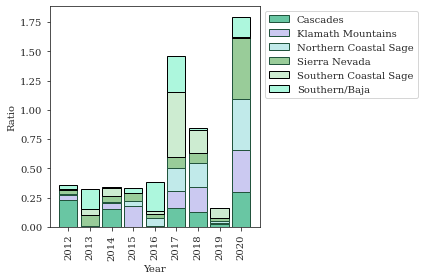

In [ ]:
fire_perimeters_eco['Year'] = fire_perimeters_eco['Year'].astype('str')
fire_perimeters_dis_single['Year'] = fire_perimeters_dis_single['Year'].astype('str')
fire_perimeters_eco_500_single['Year'] = fire_perimeters_eco_500_single['Year'].astype('str')
fire_perimeters_500_dis['Year'] = fire_perimeters_500_dis['Year'].astype('str')
fire_perimeters_eco_500['Year'] = fire_perimeters_eco_500['Year'].astype('str')

# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
  
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

r = (1, 2, 3, 4, 5, 6, 7, 8, 9)
# plot. 
barWidth = 0.85
# Create Type1
plt.bar(r, Type1, 
        color='#69c6a3', edgecolor='#22543D', width=barWidth, 
        label="Cascades")
# Create Type2
plt.bar(r, Type2, bottom=Type1, 
        color='#cbc9f1', edgecolor='#22543D', width=barWidth, 
        label="Klamath Mountains")
# Create Type3
plt.bar(r, Type3, bottom=[i+j for i,j in zip(Type1, Type2)], 
        color='#c1eaea', edgecolor='#22543D', width=barWidth, 
        label="Northern Coastal Sage")

# Type4 
plt.bar(r, Type4, bottom=[i+j+k for i,j,k in zip(Type1, Type2, Type3)], 
        color='#99cc99', edgecolor='#22543D', width=barWidth, 
        label="Sierra Nevada")

# Type5
plt.bar(r, Type5, bottom=[i+j+k+l for i,j,k,l in zip(Type1, Type2, Type3, Type4)], 
        color='#cdecd1', edgecolor='black', width=barWidth, 
        label="Southern Coastal Sage")

# Type6
plt.bar(r, Type6, bottom=[i+j+k+l+m for i,j,k,l,m in zip(Type1, Type2, Type3, Type4, Type5)], 
        color='#adf7dd', edgecolor='black', width=barWidth, 
        label="Southern/Baja")

# sns.lineplot(x='Year', y='Total Area (acres)', 
#                    data = fire_perimeters_500_dis, legend=False)

# Custom x axis
plt.xticks(r, nameList)
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.tight_layout()
# plt.savefig(os.path.join(figOutPath, varname + "_FeatureImportance_Stacked.png"), dpi = 200)
# Show graphic

In [ ]:
# percent_by_yr = percent_by_yr[['Year', 'ecoID', 'Ratio']]
# percent_by_yr = percent_by_yr[percent_by_yr['ecoID'].isin(['Cascades', 'Southern Coastal Sage', 'Northern Coastal Sage',\
#                                                                        'Sierra Nevada', 'Klamath Mountains', 'Southern/Baja'])]
# percent_by_yr = percent_by_yr.set_index('Year').fillna(0)
# percent_by_yr_piv = percent_by_yr.pivot(columns='ecoID', values='Ratio')

fire_perimeters_500_dis['Total Area (ha)'] = fire_perimeters_500_dis['Total Area (acres)'] * 0.404686

fire_perimeters_500_dis = fire_perimeters_500_dis[['Total Area (ha)']]
# fire_perimeters_500_dis = fire_perimeters_500_dis.set_index('Year').fillna(0)
# fire_perimeters_500_dis = fire_perimeters_500_dis.sort_index()

In [ ]:
fire_perimeters_500_dis

In [ ]:
flatui2 = ['#bebbed', '#7e78dc', '#35ccff', '#05a167', '#66b266', '#32ecab']
pal2 = sns.set_palette(sns.color_palette(flatui2))

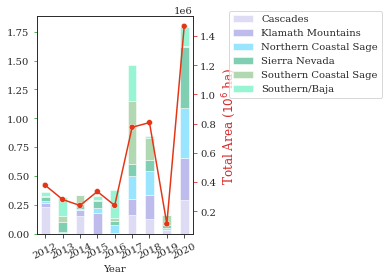

In [ ]:
#fig, ax1 = plt.subplots(figsize=(10,6))
plot_options = {'labelrotation':25}
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax1.set_ylabel('Ratio', fontsize=12, color='tab:green')
ax1 = percent_by_yr_piv.plot(kind='bar',stacked=True, legend=False, alpha=0.5, color=flatui2)
ax1.tick_params(axis='y', color='tab:green')
ax1.tick_params(axis='x', **plot_options)


ax2 = ax1.twinx()

ax2.set_ylabel('Total Area ($10^6$ ha)', fontsize=12, color='tab:red')
ax2 = sns.lineplot(data = fire_perimeters_500_dis, markers=False, legend=False, color='red', linewidth = 1.5)
ax2 = sns.scatterplot(data = fire_perimeters_500_dis, markers=True, legend=False, color='red')
ax2.tick_params(axis='y', color='tab:red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2 , labels + labels2 , bbox_to_anchor=(1.20, 1.05), framealpha=0.75)

plt.tight_layout()
# plt.savefig(f'Figures/Regional_Timeseries_Ratio_Legend.png', dpi=400)

In [ ]:
fire_perimeters_500_dis.iloc[:9, 0]

Year
2012    3.777216e+05
2013    2.800566e+05
2014    2.393569e+05
2015    3.348914e+05
2016    2.396944e+05
2017    7.752842e+05
2018    8.074884e+05
2019    1.132233e+05
2020    1.467377e+06
Name: Total Area (ha), dtype: float64

In [ ]:
395964.6

In [ ]:
fire_perimeters_eco['Year'] = fire_perimeters_eco['Year'].astype('str')
fire_perimeters_dis_single['Year'] = fire_perimeters_dis_single['Year'].astype('str')
fire_perimeters_eco_500_single['Year'] = fire_perimeters_eco_500_single['Year'].astype('str')
fire_perimeters_500_dis['Year'] = fire_perimeters_500_dis['Year'].astype('str')
fire_perimeters_eco_500['Year'] = fire_perimeters_eco_500['Year'].astype('str')

fig, ax1 = plt.subplots(figsize=(10,6))

# ax1 = sns.histplot(x='Year', color='#dfdcda',  
#                    linewidth=0.2,
#                    data = fire_perimeters_dis_single)

flatui = ["#e33617","#e6e5c1", '#fabb01', "#80cbc9", '#d6d498', "#80cbc9", "#80cbc9"]
pal = sns.color_palette(flatui)

# ax1 = sns.histplot(x='Year', palette=pal,  \
#              hue = 'ecoID', hue_order=['Cascades', 'Southern Coastal Sage', 'Northern Coastal Sage',
#                         'Klamath Mountains', 'Sierra Nevada', 'Eastern Cascades',
#                         'Southern/Baja'], fill=True,linewidth=0.5, 
#                    data = fire_perimeters_eco_500_single, )
# ax1.set_ylim(0,1000)

ax1 = sns.catplot(
    data=new_fire_perimeters_eco_500, kind="bar",
    x="Year", y="Deviation", hue="ecoID", 
    palette="dark", alpha=.6, height=6
)

# def change_width(ax, new_value) :
#     for patch in ax.patches :
#         current_width = patch.get_width()
#         diff = current_width - new_value

#         # we change the bar width
#         patch.set_width(new_value)

#         # we recenter the bar
#         patch.set_x(patch.get_x() + diff * .5)

# change_width(ax1, 0.9)

# countvalslst = fire_perimeters_dis_single['Fire Count'].values.tolist()

# for p, label in zip(ax1.patches, countvalslst):
#     ax1.annotate(label, (p.get_x()+0.375, p.get_height()+0.15))


ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Area Burned', fontsize=16)
new_fire_perimeters_eco_500 = new_fire_perimeters_eco_500.sort_values(by='Year')
ax2 = sns.lineplot(x='Year', y='Total Area (acres)', 
                   data = fire_perimeters_500_dis, legend=False, color=color)

ax2.tick_params(axis='y', color=color)
# plt.savefig('Figures/CA_Fire_Count_Regions.png', dpi = 400)

In [ ]:
fire_perimeters_eco['Year'] = fire_perimeters_eco['Year'].astype('str')

sns.barplot(x='Year', y='Total Area (acres)',\
             hue_order=['Cascades', 'Southern Coastal Sage', 'Northern Coastal Sage',
                        'Klamath Mountains', 'Sierra Nevada', 'Eastern Cascades',
                        'Southern/Baja'],# legend=None,#multiple="stack",
                   data = fire_perimeters_eco, )

sns.lineplot(x='Year', y='Total Area (acres)',\
             hue_order=['Cascades', 'Southern Coastal Sage', 'Northern Coastal Sage',
                        'Klamath Mountains', 'Sierra Nevada', 'Eastern Cascades',
                        'Southern/Baja'],# legend=None,#multiple="stack",
                   data = fire_perimeters_eco, )

In [ ]:
fire_perimeters_500_grp = fire_perimeters_500.groupby('Year').agg({'IncidentName': ('count'),\
                                     'Area': ('sum', )
                                     }).reset_index()

fire_perimeters_500_grp.columns = ['Year', 'Fire Count (>500 acres)', 'Total Area (>500 acres)']
fire_perimeters_500_grp

In [ ]:
fire_perimeters = gpd.read_file('Data/Interagency_FirePerimeters/CALIFORNIA/Combined_2012_2020/Perimeters_2012_2020.geojson')

In [ ]:
fire_perimeters_dis = fire_perimeters.dissolve(by='Year')

In [ ]:
fire_perimeters_grp = fire_perimeters.groupby('Year').agg({'IncidentName': ('count'),\
                                     'Area': ('sum', )
                                     }).reset_index()

fire_perimeters_grp.columns = ['Year', 'Fire Count', 'Total Area (acres)']
annual_fire_info = fire_perimeters_grp.merge(fire_perimeters_500_grp, on='Year')

In [ ]:
fire_perimeters_dis = fire_perimeters.dissolve(by='Year')

In [ ]:
fire_perimeters_dis["Total Area (acres)"] = fire_perimeters_dis.geometry.area * 0.0002471054 

In [ ]:
fire_perimeters_dis = fire_perimeters_dis.reset_index()
fire_perimeters_dis[['Year', 'Total Area (acres)', 'geometry']]

In [ ]:
annual_fire_info['Year'] = annual_fire_info['Year'].astype('str')

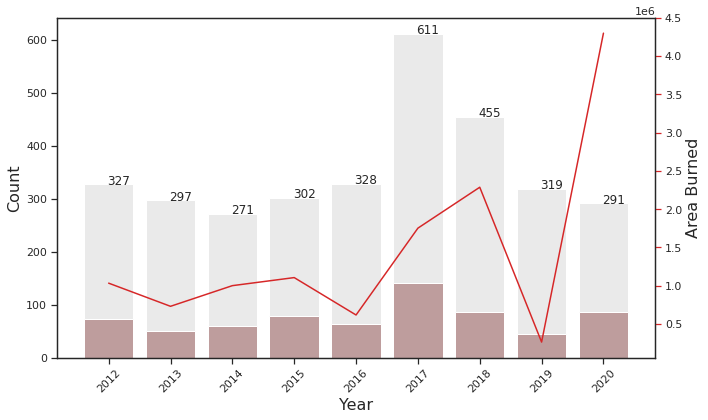

In [ ]:
import seaborn as sns
sns.set(style='ticks')
# Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
# bar plot creation
# ax1.set_title('Western US: GeoMac Fire Count', fontsize=16)

ax1 = sns.barplot(x='Year', y = 'Fire Count', data = annual_fire_info, color='#eaeaea')
ax1.tick_params(axis='y')
ax1 = sns.barplot(x='Year', y = 'Fire Count (>500 acres)', data = annual_fire_info, color='#c39797')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Count', fontsize=16)

countvalslst = annual_fire_info['Fire Count'].values.tolist()

for p, label in zip(ax1.patches, countvalslst):
    ax1.annotate(label, (p.get_x()+0.375, p.get_height()+0.15))

ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Area Burned', fontsize=16)
ax2 = sns.lineplot(x='Year', y='Total Area (>500 acres)', data = annual_fire_info, color=color, )
ax2.tick_params(axis='y', color=color)

plt.tight_layout()
plt.savefig('Figures/CA_Fire_Count.png', dpi = 400)

In [ ]:
annual_fire_info

,Year,Fire Count,Total Area (acres),Fire Count (>500 acres),Total Area (>500 acres)
0,2012,327,1.048154e+06,72,1.031635e+06
1,2013,297,7.474421e+05,50,7.290410e+05
2,2014,271,1.011061e+06,59,9.990179e+05
3,2015,302,1.120940e+06,79,1.104348e+06
4,2016,328,6.329766e+05,63,6.156031e+05
5,2017,611,1.780915e+06,140,1.750490e+06
6,2018,455,2.309699e+06,86,2.285202e+06
7,2019,319,2.797806e+05,45,2.616704e+05
8,2020,291,4.303969e+06,86,4.298607e+06
